## DATA SCIENCE CAPSTONE - JAKE DARBY

##### The Data files I am using include my own personal Spotify streaming data, consisting of over 17,000 songs. I will be using the songs I have listened to the past few years to determine, by the attributes of each song, which genres I tend to enjoy the most, and, from there, find new automatically generated albums for me to listen to based on the music I have already enjoyed in the past.

##### The streaming files are separated in two, and are in the json format, so I can import them both and append them into one dataframe using pandas.

In [112]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json
import pandas as pd

In [114]:
with open('StreamingHistory0.json') as data0:
  stream0 = json.load(data0)
with open('StreamingHistory1.json') as data1:
  stream1 = json.load(data1)
stream_df0 = pd.DataFrame(stream0)
stream_df1 = pd.DataFrame(stream1)
stream_df = stream_df0.append(stream_df1)

stream_df.head()

UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 21819: character maps to <undefined>

##### Spotify only gives me the date, artist, track, and time spent listening to the track. I need to uncover more about each song in order to evaluate this data. To do this, I will utilize the Spotify API as well as SpotiPy to make a search query, allowing me to retrieve the ID's Spotify associates with each track. To use this API, we will need the "client id's" and "client secret id's" associated with my account, which I can obtain from the Spotify Developer page.

In [15]:
client_id = 'a3d6d87d03994a91883e343e37baff9d'
client_secret = '6182efe43d384dd9b431151ea75d6901'

client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [16]:
import requests
import datetime
from urllib.parse import urlencode
import base64

In [6]:
class SpotifyAPI(object):
    access_token = None
    access_token_expires = datetime.datetime.now()
    access_token_did_expire = True
    client_id = None
    client_secret = None
    token_url = "https://accounts.spotify.com/api/token"
    
    def __init__(self, client_id, client_secret, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.client_id = client_id
        self.client_secret = client_secret
    
    def get_client_credentials(self):
        client_id = self.client_id
        client_secret = self.client_secret
        if client_secret == None or client_id == None:
            raise Exception("You must set client_id and client_secret")
        client_creds = f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())
        return client_creds_b64.decode()
    
    
    def get_token_headers(self):
        client_creds_b64 = self.get_client_credentials()
        return {
            "Authorization": f"Basic {client_creds_b64}"
        }
    def get_token_data(self):
        return {
            "grant_type": "client_credentials"
        }
    
    def perform_auth(self):
        token_url = self.token_url
        token_data = self.get_token_data()
        token_headers = self.get_token_headers()
        r = requests.post(token_url, data = token_data, headers = token_headers)
        if r.status_code not in range(200, 299):
            raise Exception("Could not authenticate client.")
        data = r.json()
        now = datetime.datetime.now()
        access_token = data['access_token']
        expires_in = data['expires_in'] #seconds
        expires = now + datetime.timedelta(seconds = expires_in)
        self.access_token = access_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires < now
        return True
    
    def get_access_token(self):
        token = self.access_token
        expires = self.access_token_expires
        now = datetime.datetime.now()
        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        elif token == None:
            self.perform_auth()
            return self.get_access_token()
        return token
    
    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            "Authorization": f"Bearer {access_token}"
        }
        return headers
    
    def get_resource(self, lookup_id, resource_type = 'albums', version = 'v1'):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers = headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    def get_album(self, _id):
        return self.get_resource(_id, resource_type = 'albums')
    
    def get_artist(self, _id):
        return self.get_resource(_id, resource_type = 'artists')
    
    def base_search(self, query_params):
        headers = self.get_resource_header()
        endpoint = "https://api.spotify.com/v1/search"
        lookup_url = f"{endpoint}?{query_params}"
        r = requests.get(lookup_url, headers = headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    def search(self, query = None, operator = None, operator_query = None, search_type = 'artist'):
        if query == None:
            raise Exception("A query is required")
        if isinstance(query, dict):
            query = " ".join([f"{k}:{v}" for k, v in query.items()])
        if operator != None and operator_query != None:
            if operator.lower() == "or" or operator.lower() == "not":
                operator = operator.upper()
                if isinstance(operator_query, str):
                    query = f"{query} {operator} {operator_query}"
        query_params = urlencode({"q" : query, "type": search_type.lower()})
        #print(query_params)
        return self.base_search(query_params)

##### This API will allow me to input a song name and an artist name to find the exact ID I am looking for. I will use "A Day in the Life" by The Beatles as an example.

In [7]:
spotify = SpotifyAPI(client_id, client_secret)

In [8]:
def songToID(track, artist):
    string = track + ' ' + artist
    search = spotify.search({"track": string}, search_type = "track")
    return search['tracks']['items'][0]['id']

In [9]:
songToID('A Day in the Life', 'The Beatles')

'0hKRSZhUGEhKU6aNSPBACZ'

##### Using a separate function, I am able to loop through my Spotify streaming history and obtain every ID for the songs in that dataframe. Because of the size of that dataframe, I have left it out as it takes a very long time to run. Using the following method, I am able to then retrieve all of the track features for each ID in my dataframe, which I have saved to a csv.

In [10]:
def getTrackFeatures(id):
    meta = sp.track(id)
    features = sp.audio_features(id)

    # meta
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    release_date = meta['album']['release_date']
    length = meta['duration_ms']
    popularity = meta['popularity']

    # features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    time_signature = features[0]['time_signature']

    track = [name, album, artist, release_date, length, popularity, danceability, acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, tempo, time_signature]
    return track

In [11]:
streamDF = pd.read_csv('streams.csv')
streamDF

,Unnamed: 0,name,album,artist,release_date,length,popularity,danceability,acousticness,danceability.1,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,0,Holiday / Boulevard of Broken Dreams,American Idiot,Green Day,2004-09-21,493400,71,0.290,0.000659,0.290,0.8270,0.000003,0.3010,-3.451,0.0362,167.086,4
1,1,Jealous Guy - Remastered 2010,Imagine,John Lennon,1971-09-09,257786,66,0.489,0.877000,0.489,0.3890,0.320000,0.1050,-11.653,0.0284,131.366,4
2,2,Livin' Thing,A New World Record,Electric Light Orchestra,1976-09-01,212306,69,0.549,0.583000,0.549,0.6510,0.000000,0.1210,-7.097,0.0323,122.818,4
3,3,So Into You,A Rock And Roll Alternative,Atlanta Rhythm Section,1976-12,260866,56,0.622,0.650000,0.622,0.4090,0.023000,0.1420,-13.484,0.0362,86.173,4
4,4,Badlands,Darkness On the Edge of Town,Bruce Springsteen,1978-06-02,242453,58,0.609,0.086200,0.609,0.7780,0.000012,0.2780,-7.548,0.0485,122.614,4
5,5,Walk On the Wild Side,Transformer,Lou Reed,1972-12-01,254173,75,0.575,0.683000,0.575,0.3180,0.000202,0.0934,-16.729,0.1090,104.522,4
6,6,Lovely Day,Menagerie,Bill Withers,1977-10-29,254560,75,0.690,0.292000,0.690,0.6510,0.002410,0.1050,-8.267,0.0324,97.918,4
7,7,Mr. Blue Sky,Out of the Blue,Electric Light Orchestra,1977,303373,80,0.388,0.652000,0.388,0.3380,0.000004,0.2480,-10.054,0.0328,177.784,4
8,8,Maggie May,Every Picture Tells A Story,Rod Stewart,1971-05-18,350266,72,0.605,0.559000,0.605,0.5740,0.113000,0.0684,-10.536,0.0377,129.449,4
9,9,Fire and Rain - 2019 Remaster,Sweet Baby James (2019 Remaster),James Taylor,1970-02-01,203613,73,0.597,0.766000,0.597,0.2710,0.011900,0.0933,-17.293,0.0394,76.271,4


##### As we can see, all 17,097 songs are included in my new and improved dataframe, including all of the song attributes that I am interested in using for my project!

##### Now that I have these different song attributes, I can begin to visualize my data to see which attributes correlate well through clustering. I can pair up each attribute to test which of them correlate well. I can then visualize these correlations using the MatPlot and SciPy libraries.

In [12]:
import matplotlib.pyplot as plt
import scipy.stats

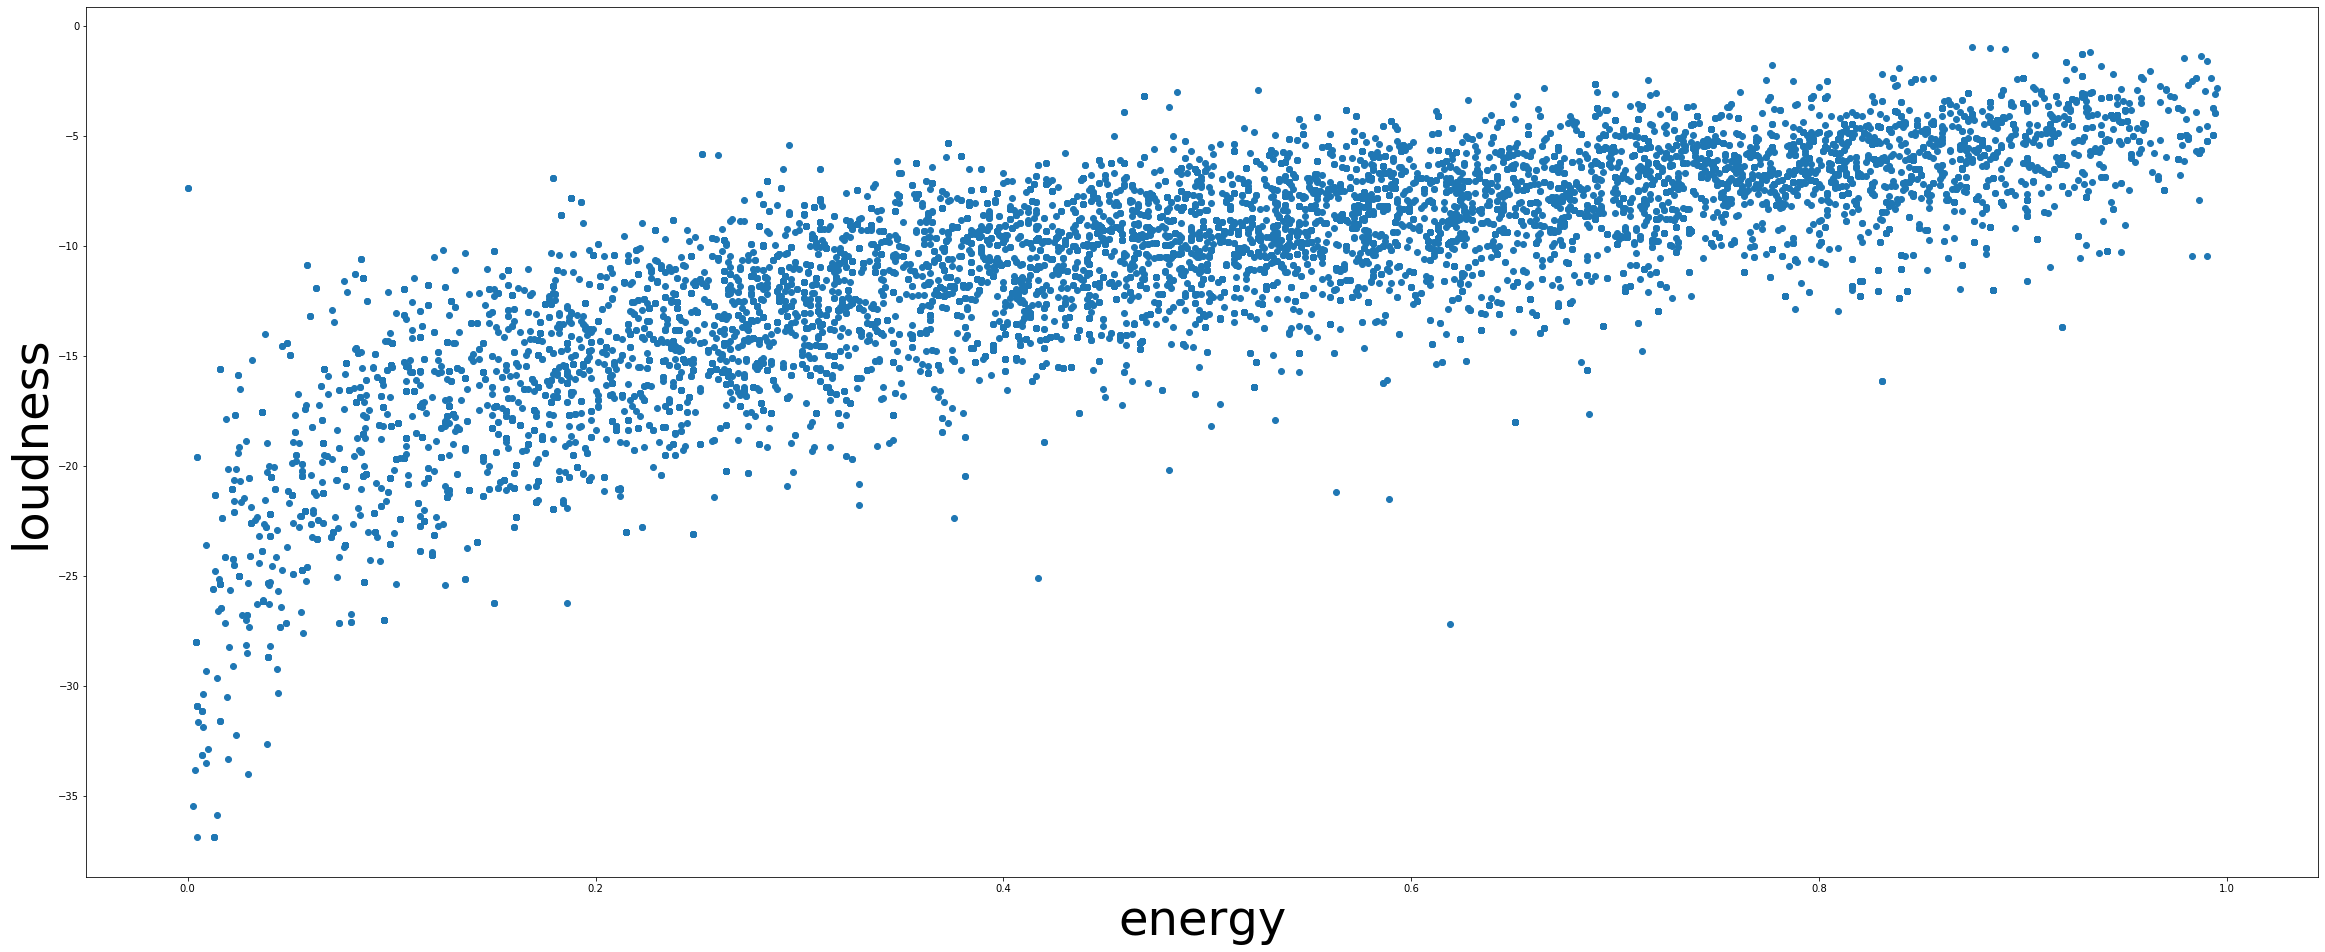

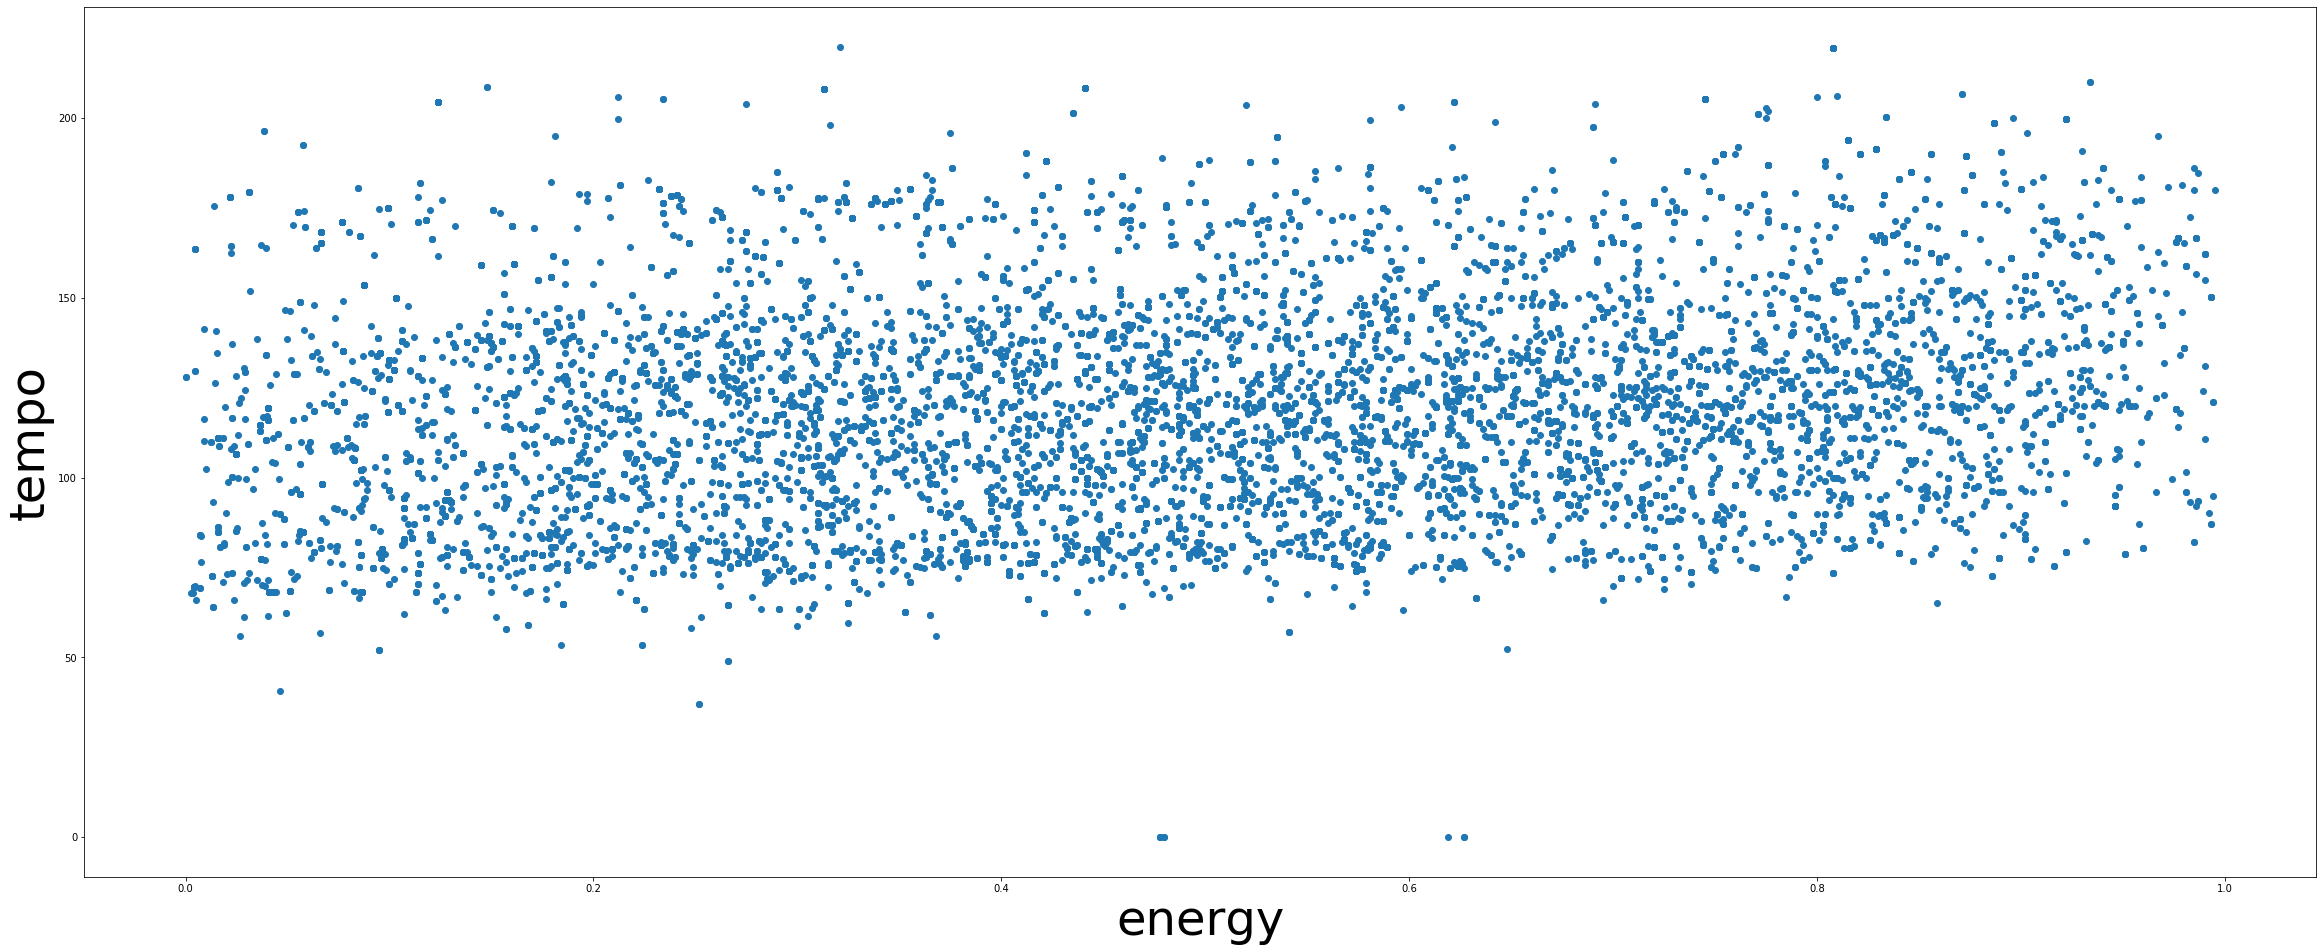

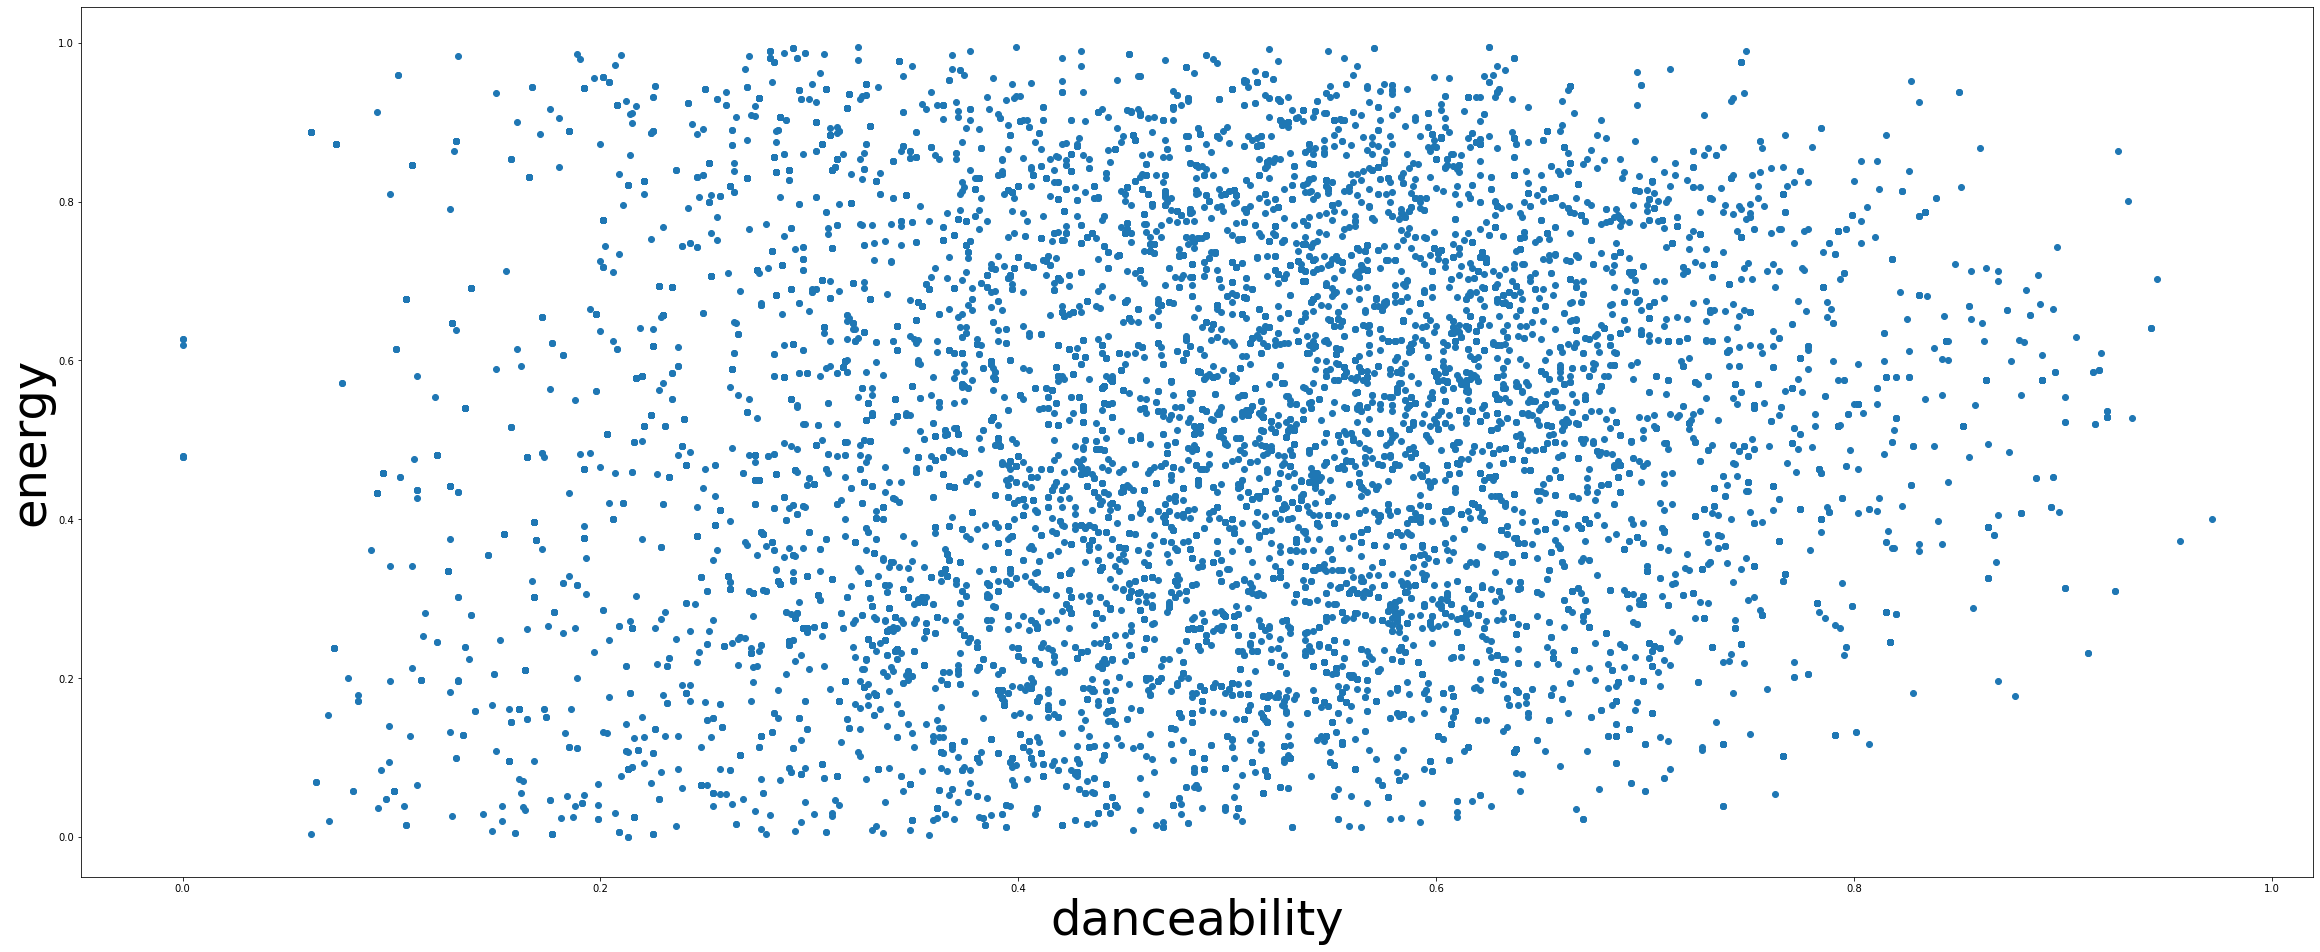

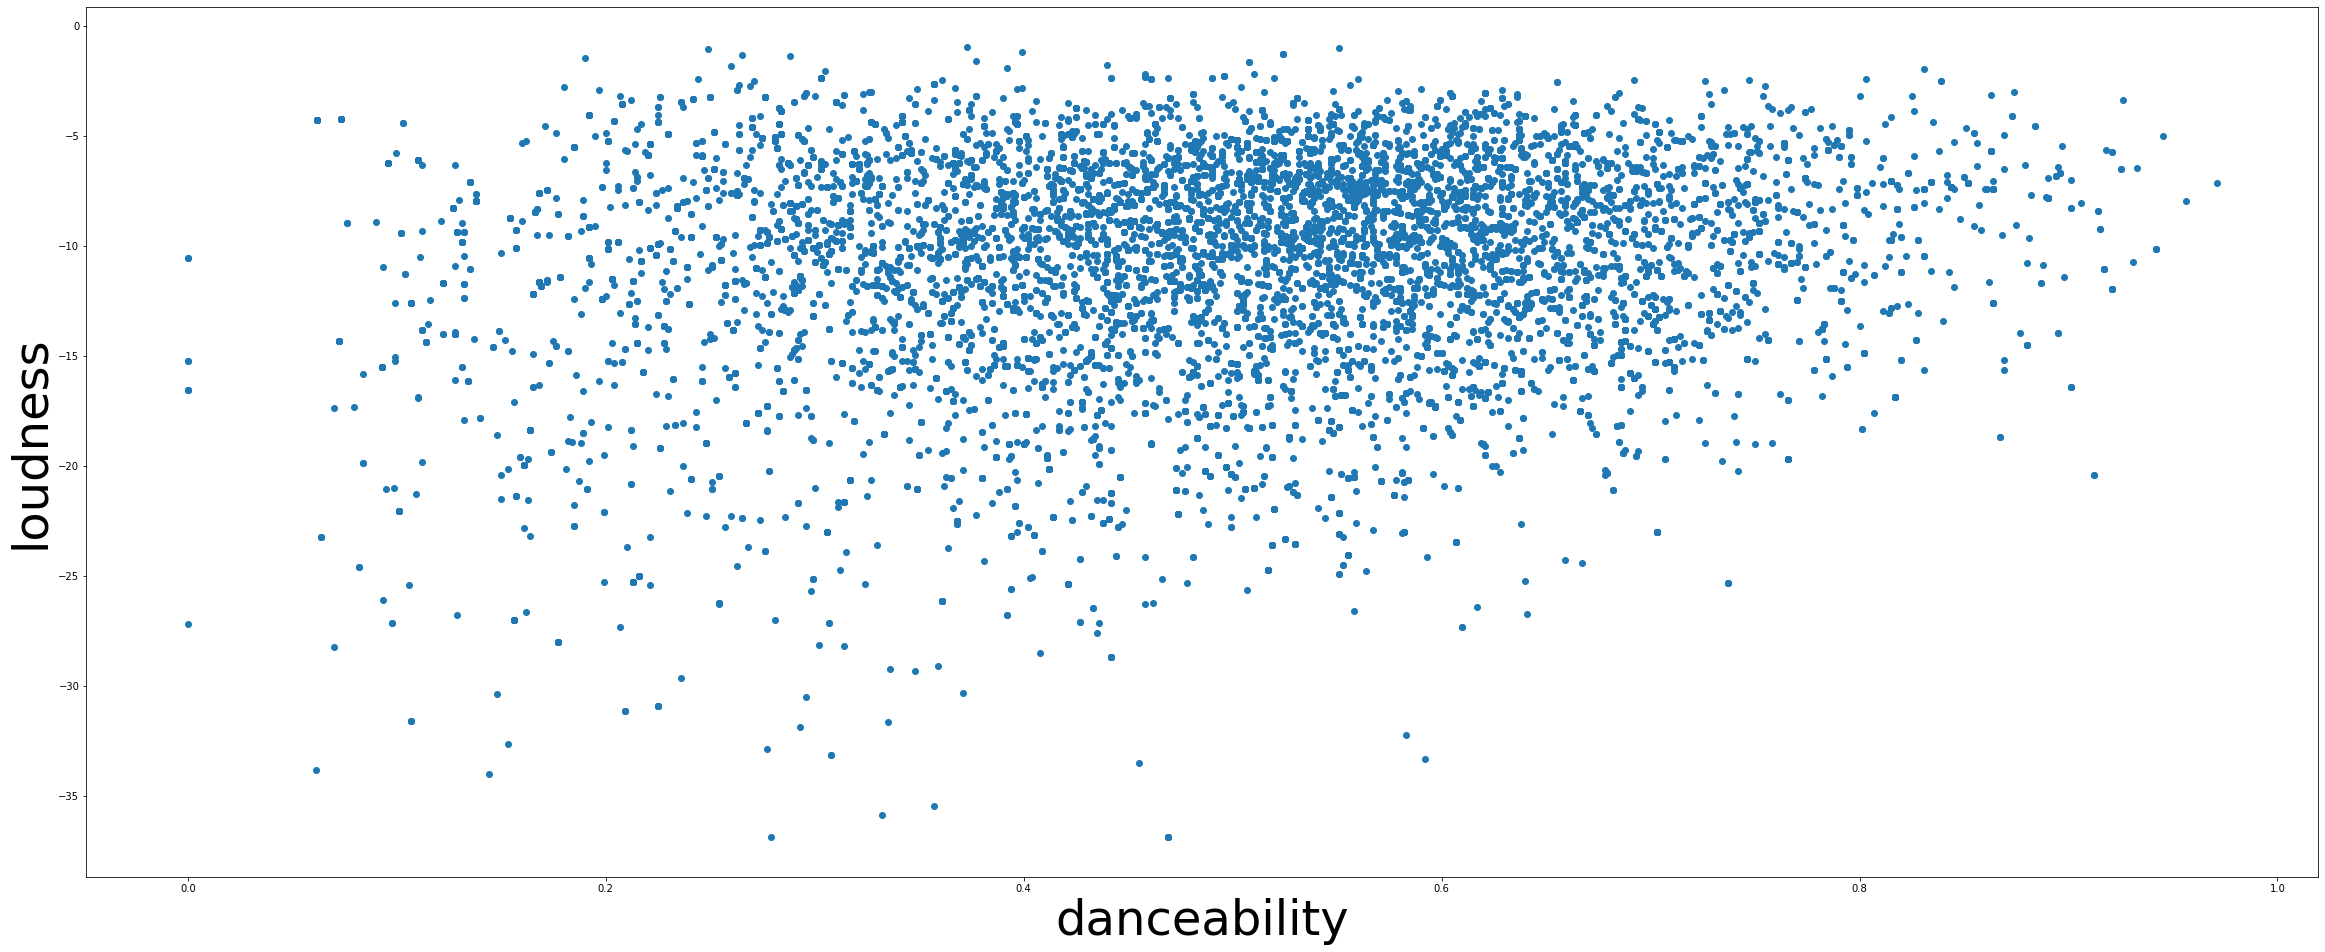

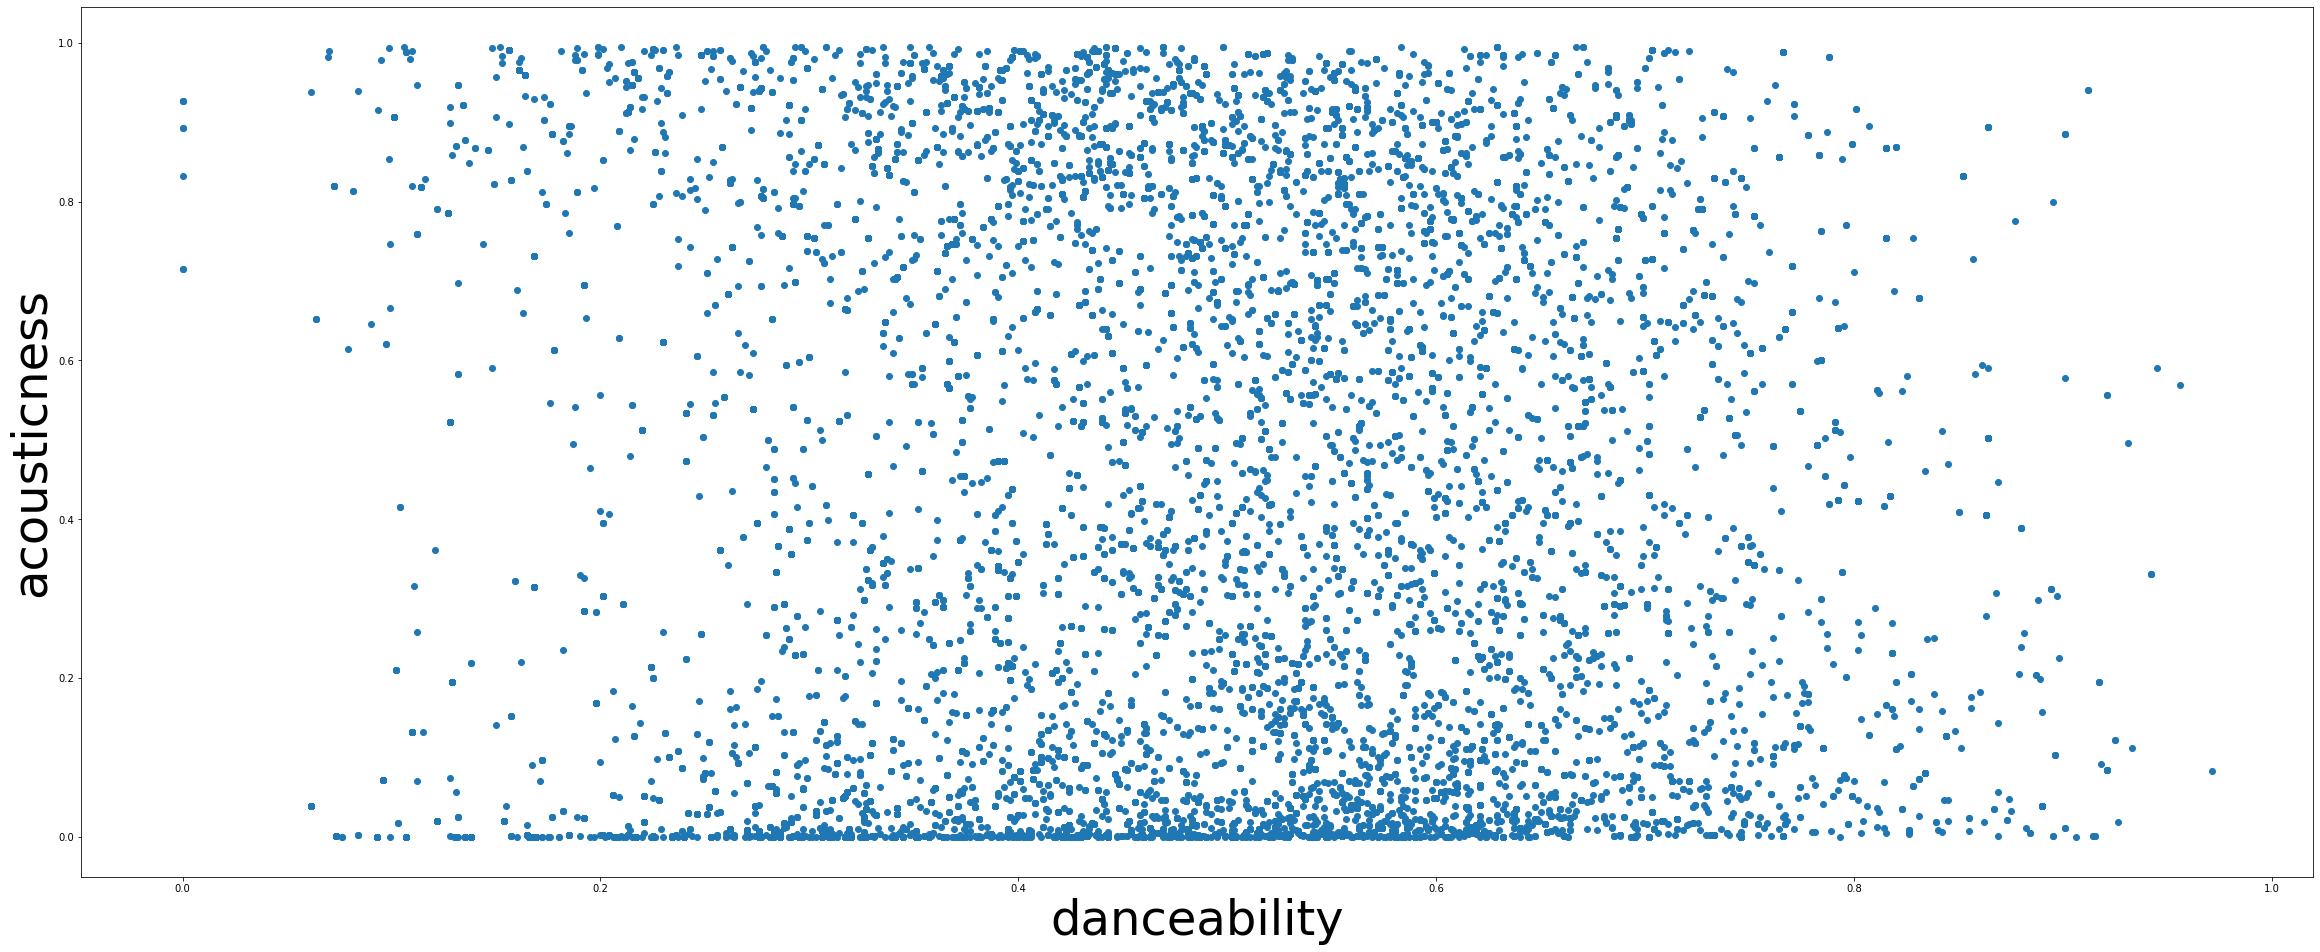

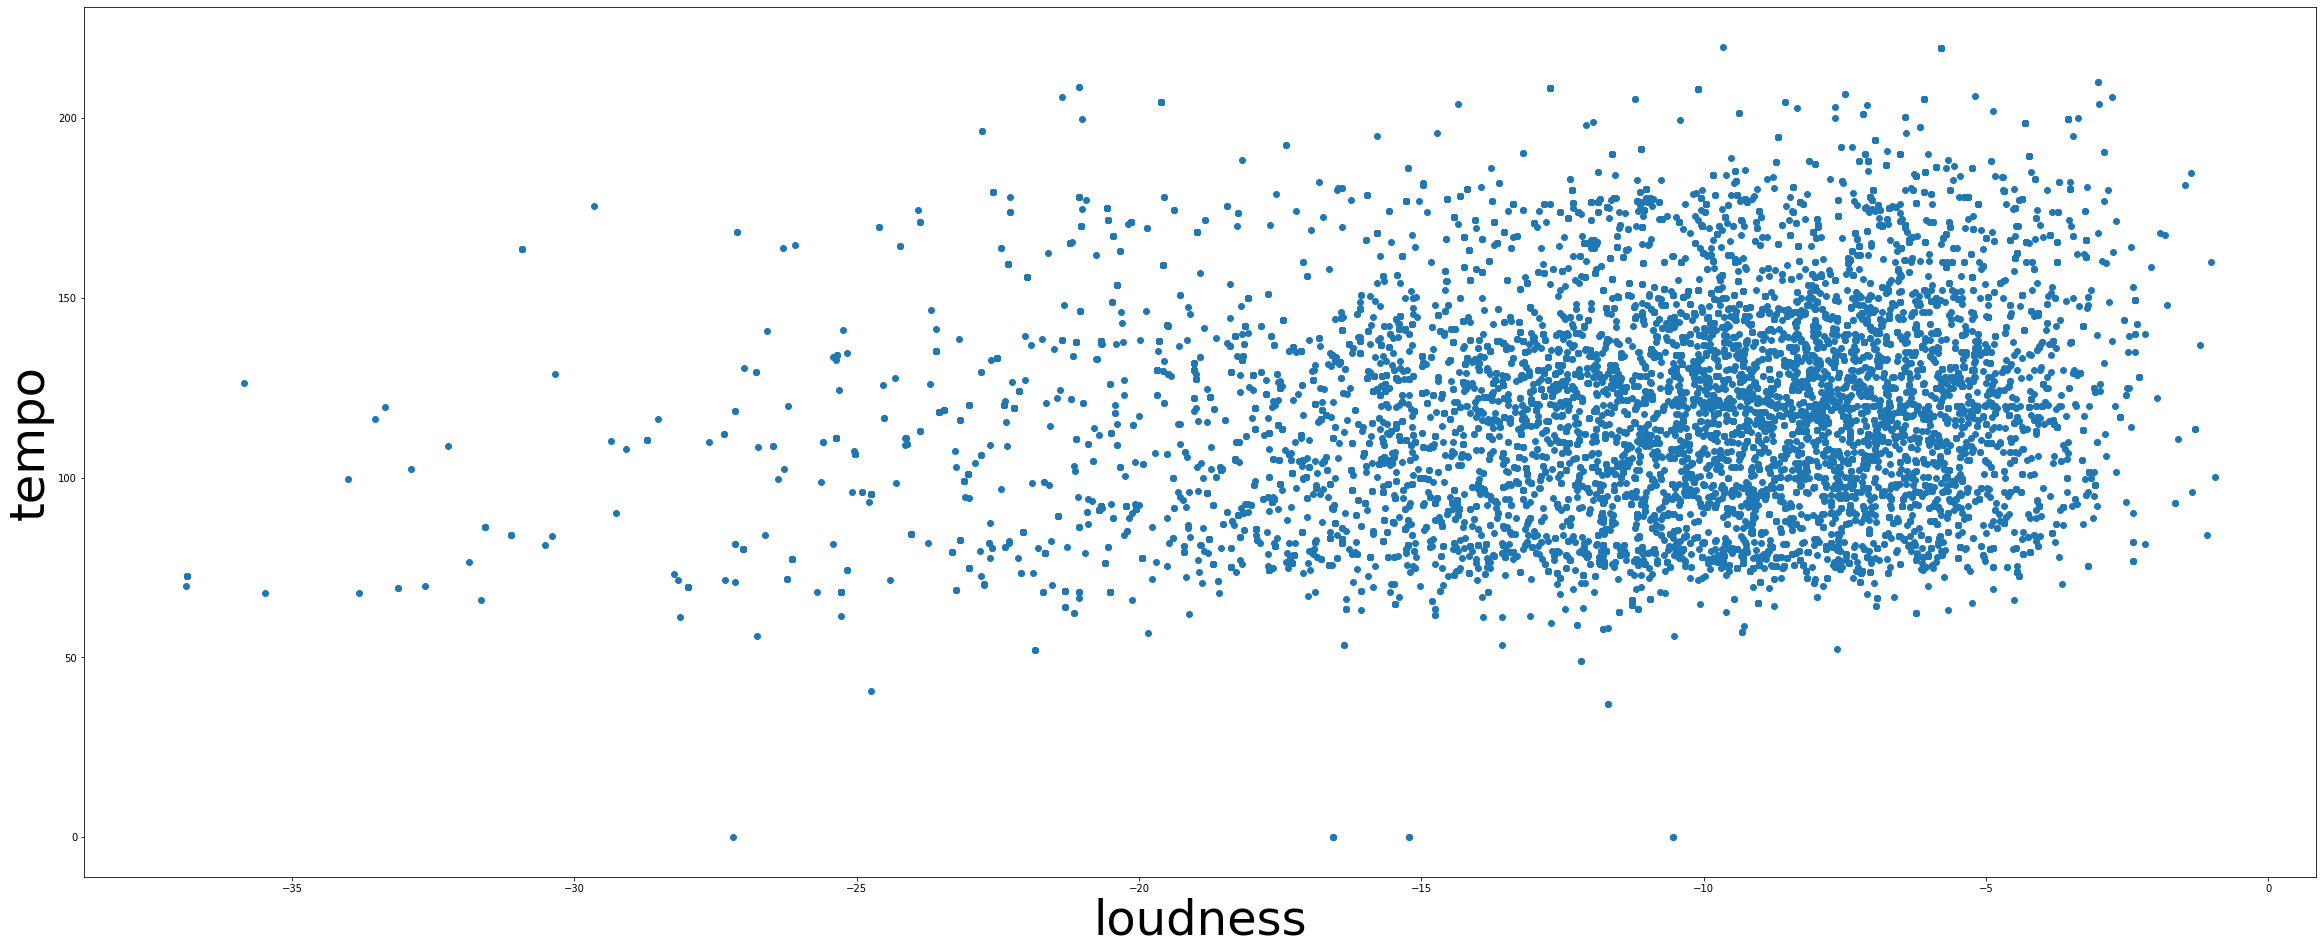

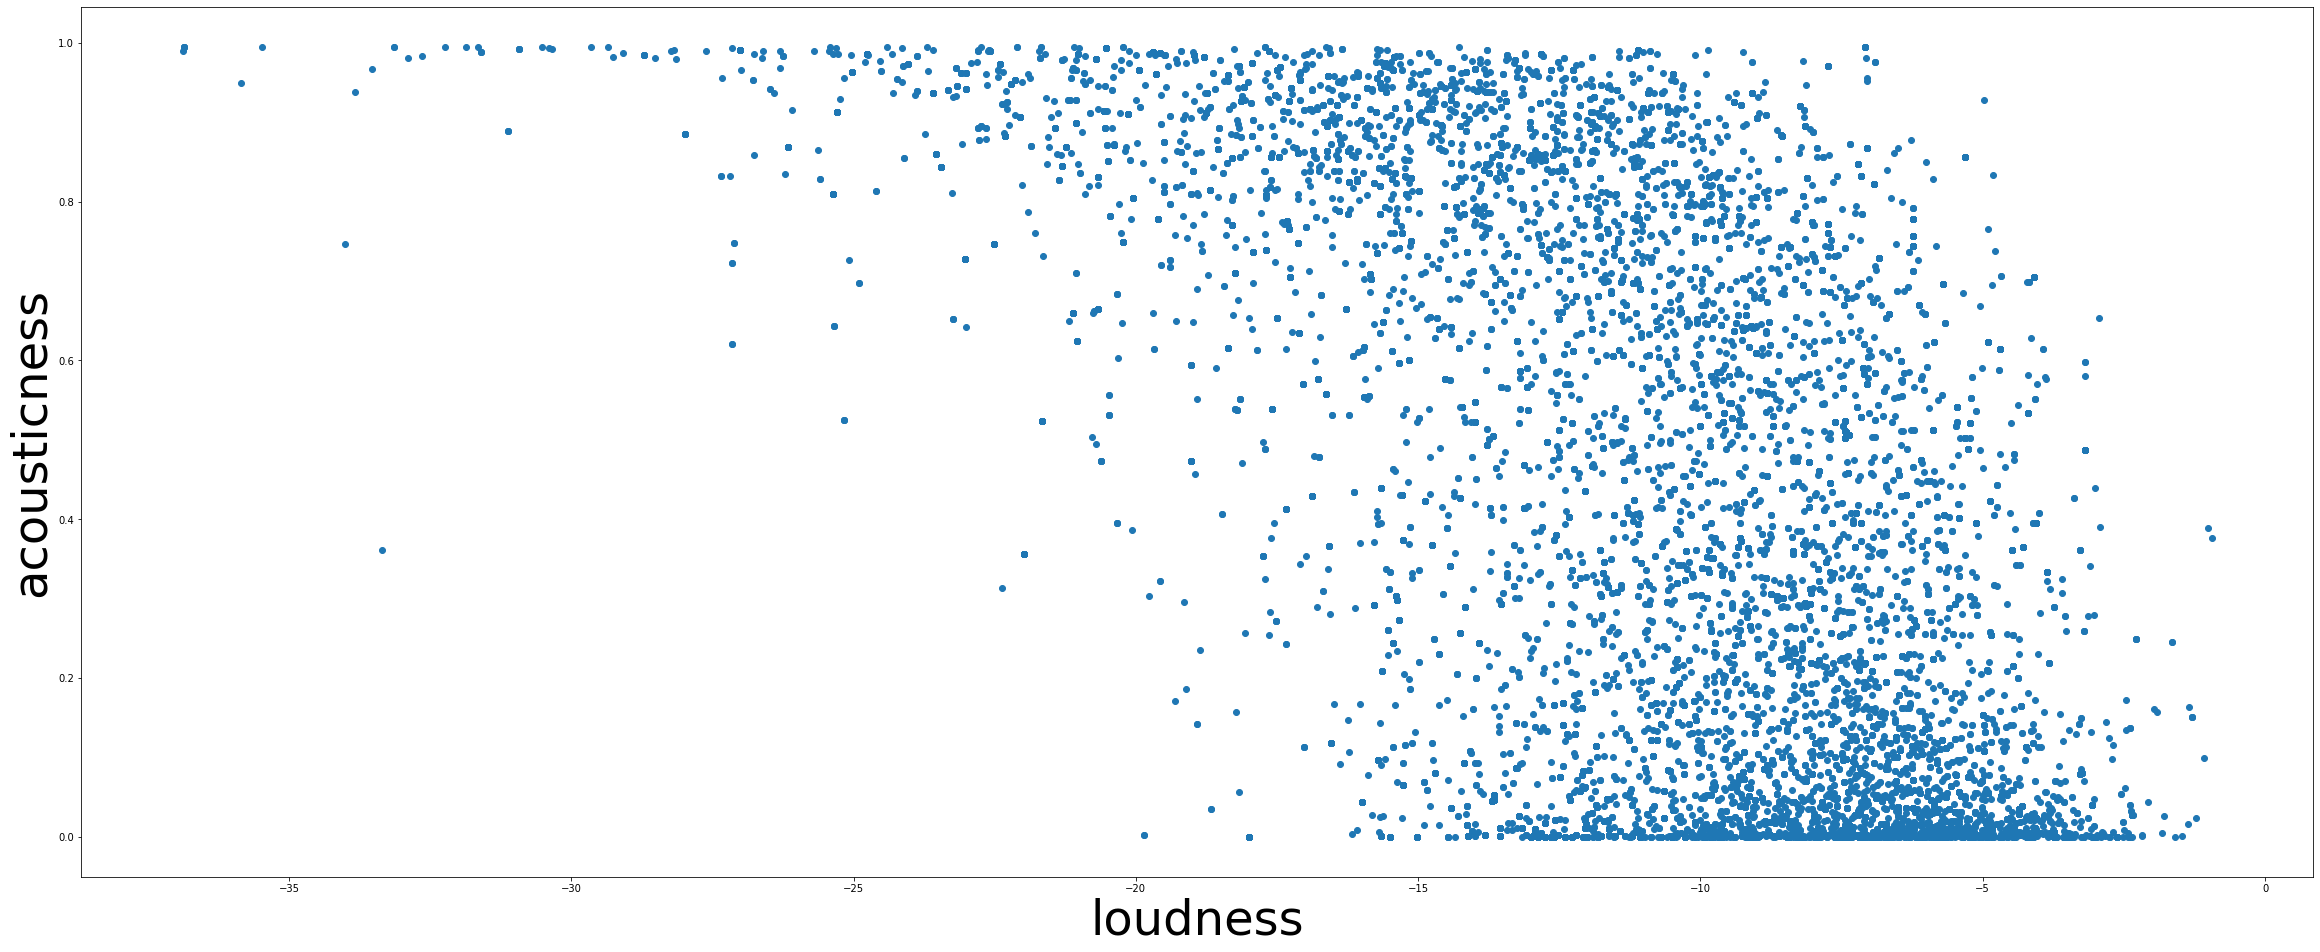

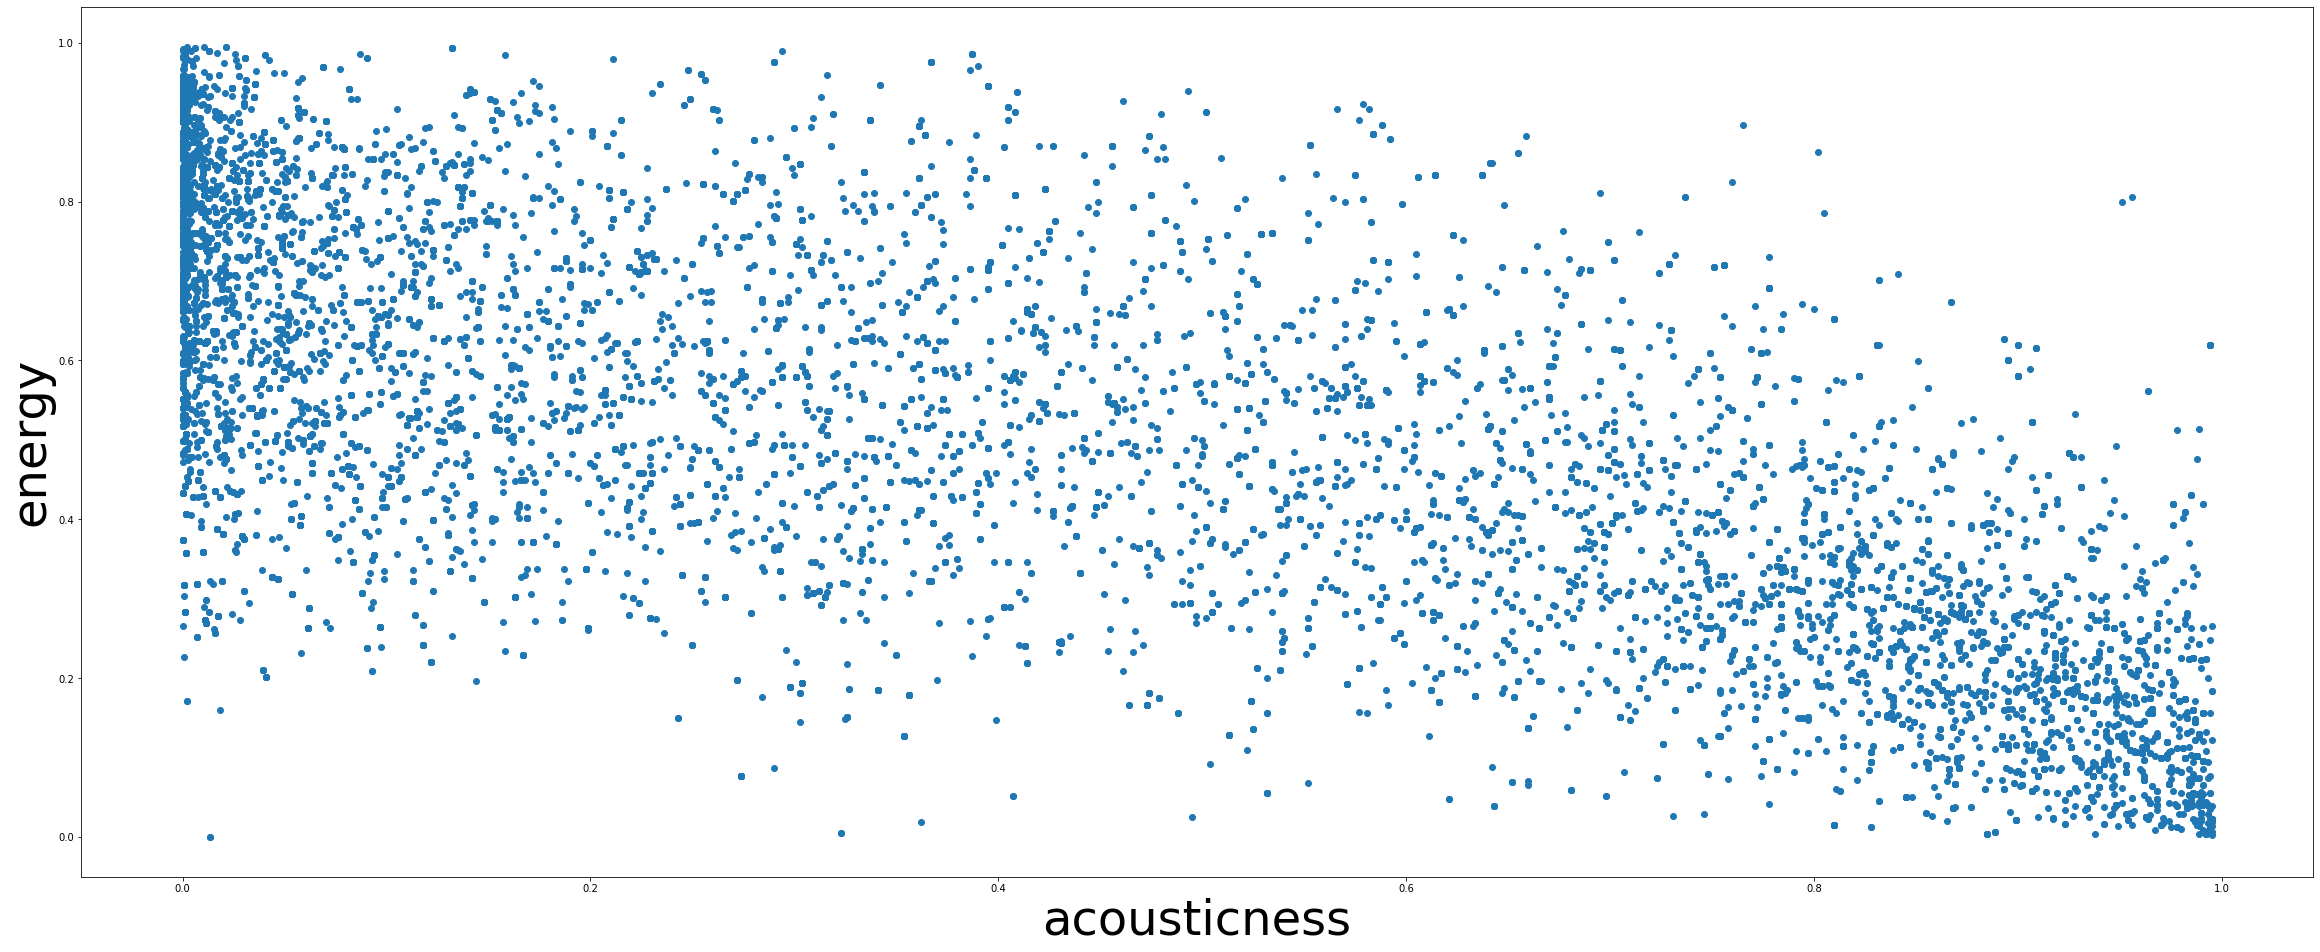

In [13]:
test_clusters = [("energy","loudness"), ("energy","tempo"), ("danceability","energy"), ("danceability","loudness") \
                ,("danceability","acousticness"), ("loudness","tempo"), ("loudness","acousticness") \
                ,("acousticness", "energy")]

for pair in test_clusters:
    plt.figure(figsize=(40,16))
    plt.plot(streamDF[pair[0]], streamDF[pair[1]],'o');
    plt.xlabel(pair[0], fontsize=48)
    plt.ylabel(pair[1], fontsize=48)

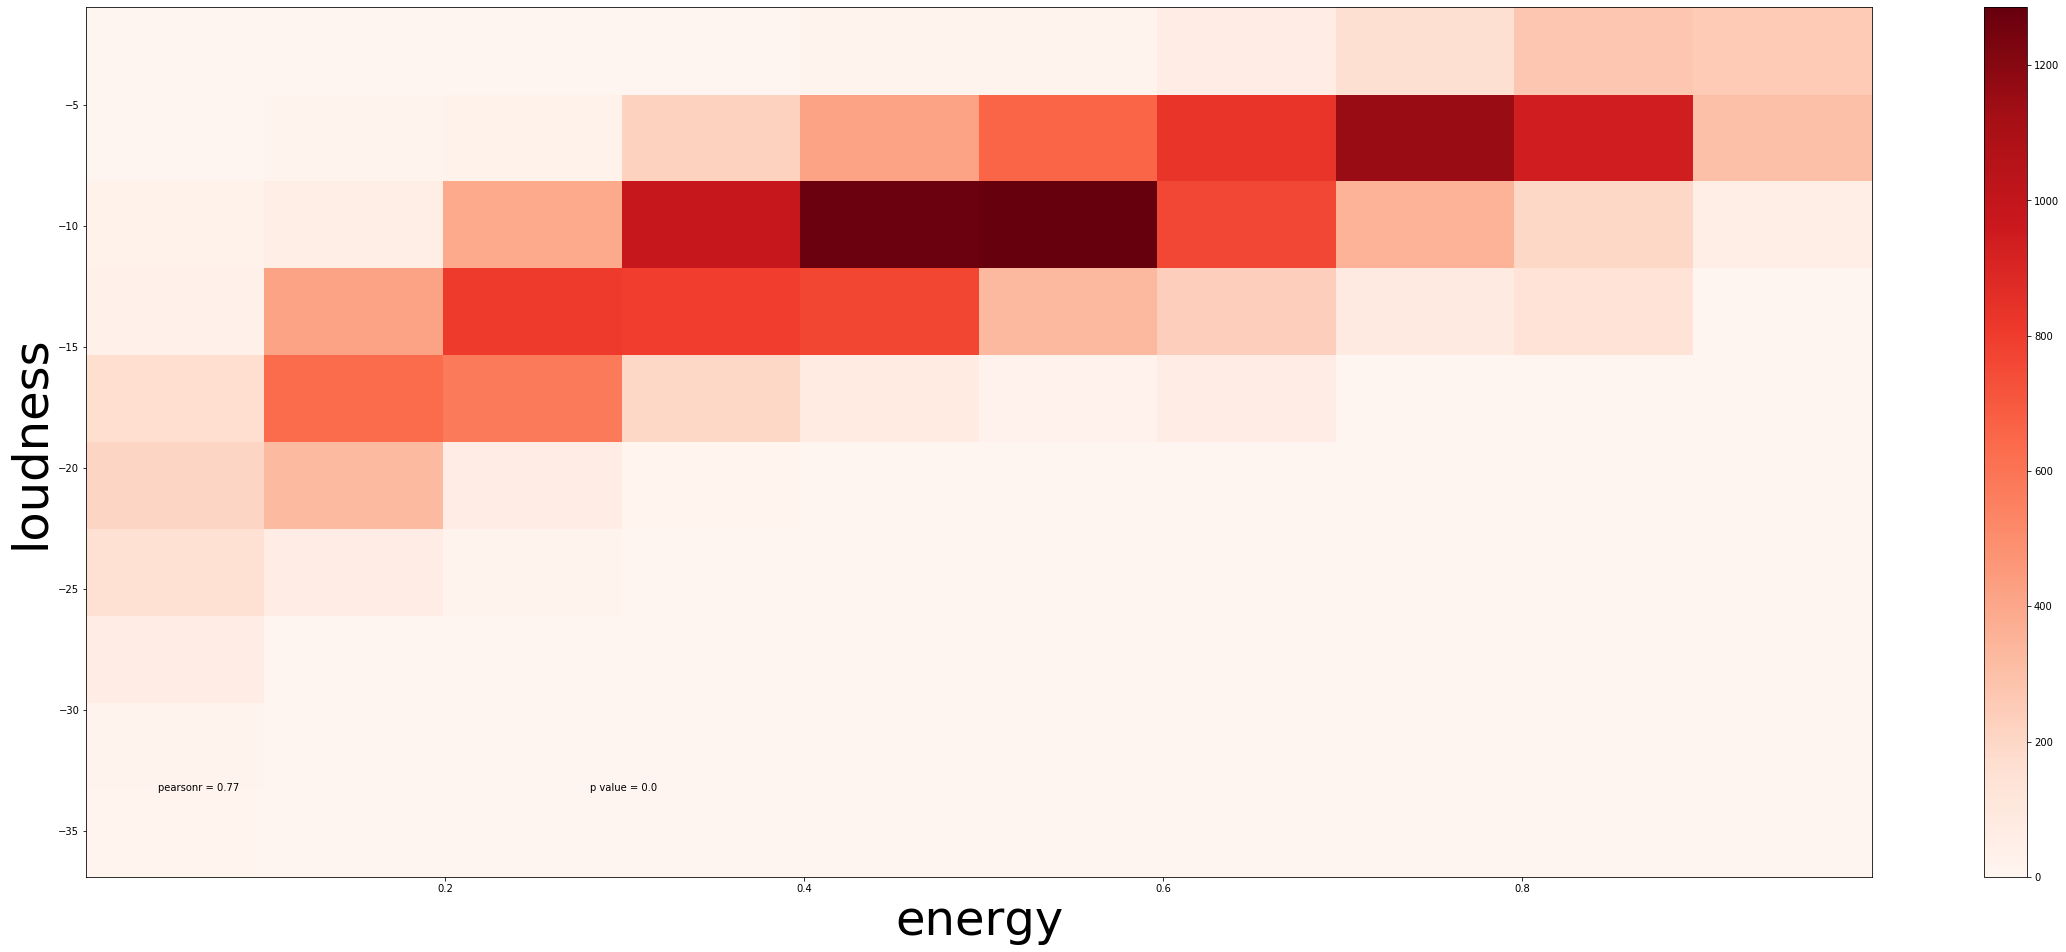

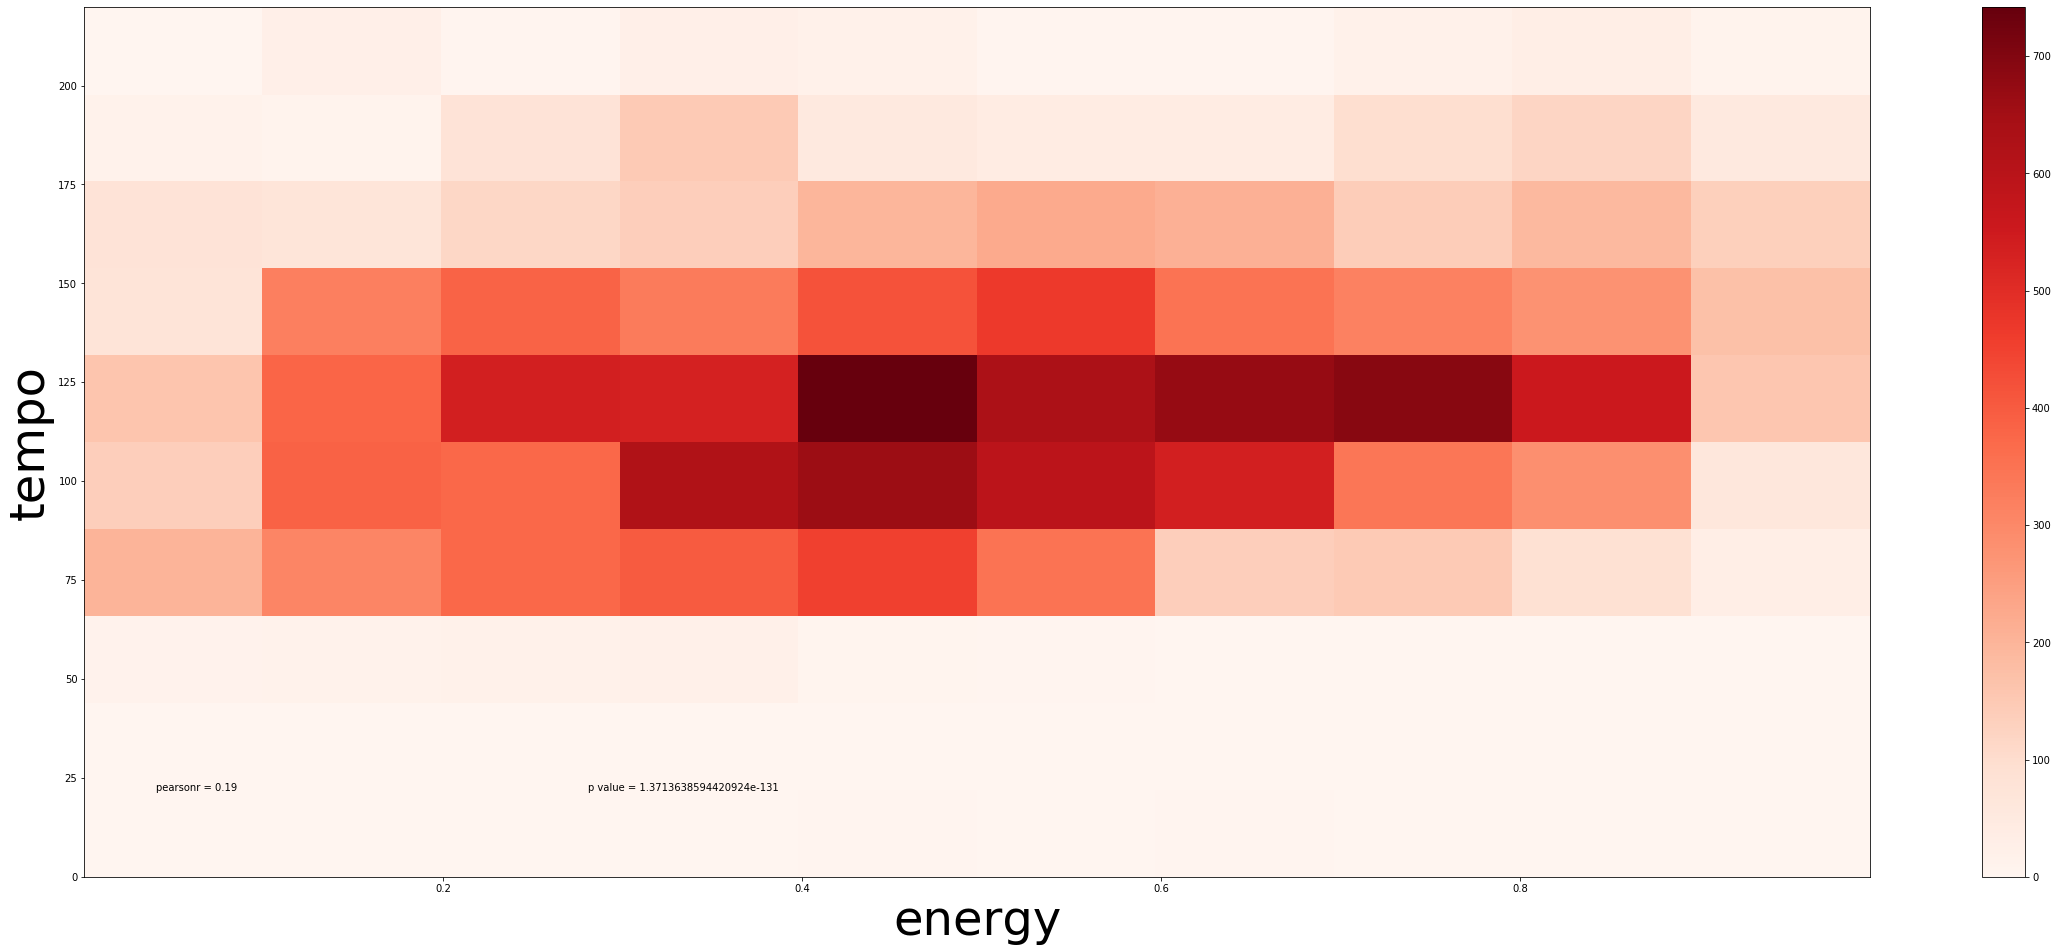

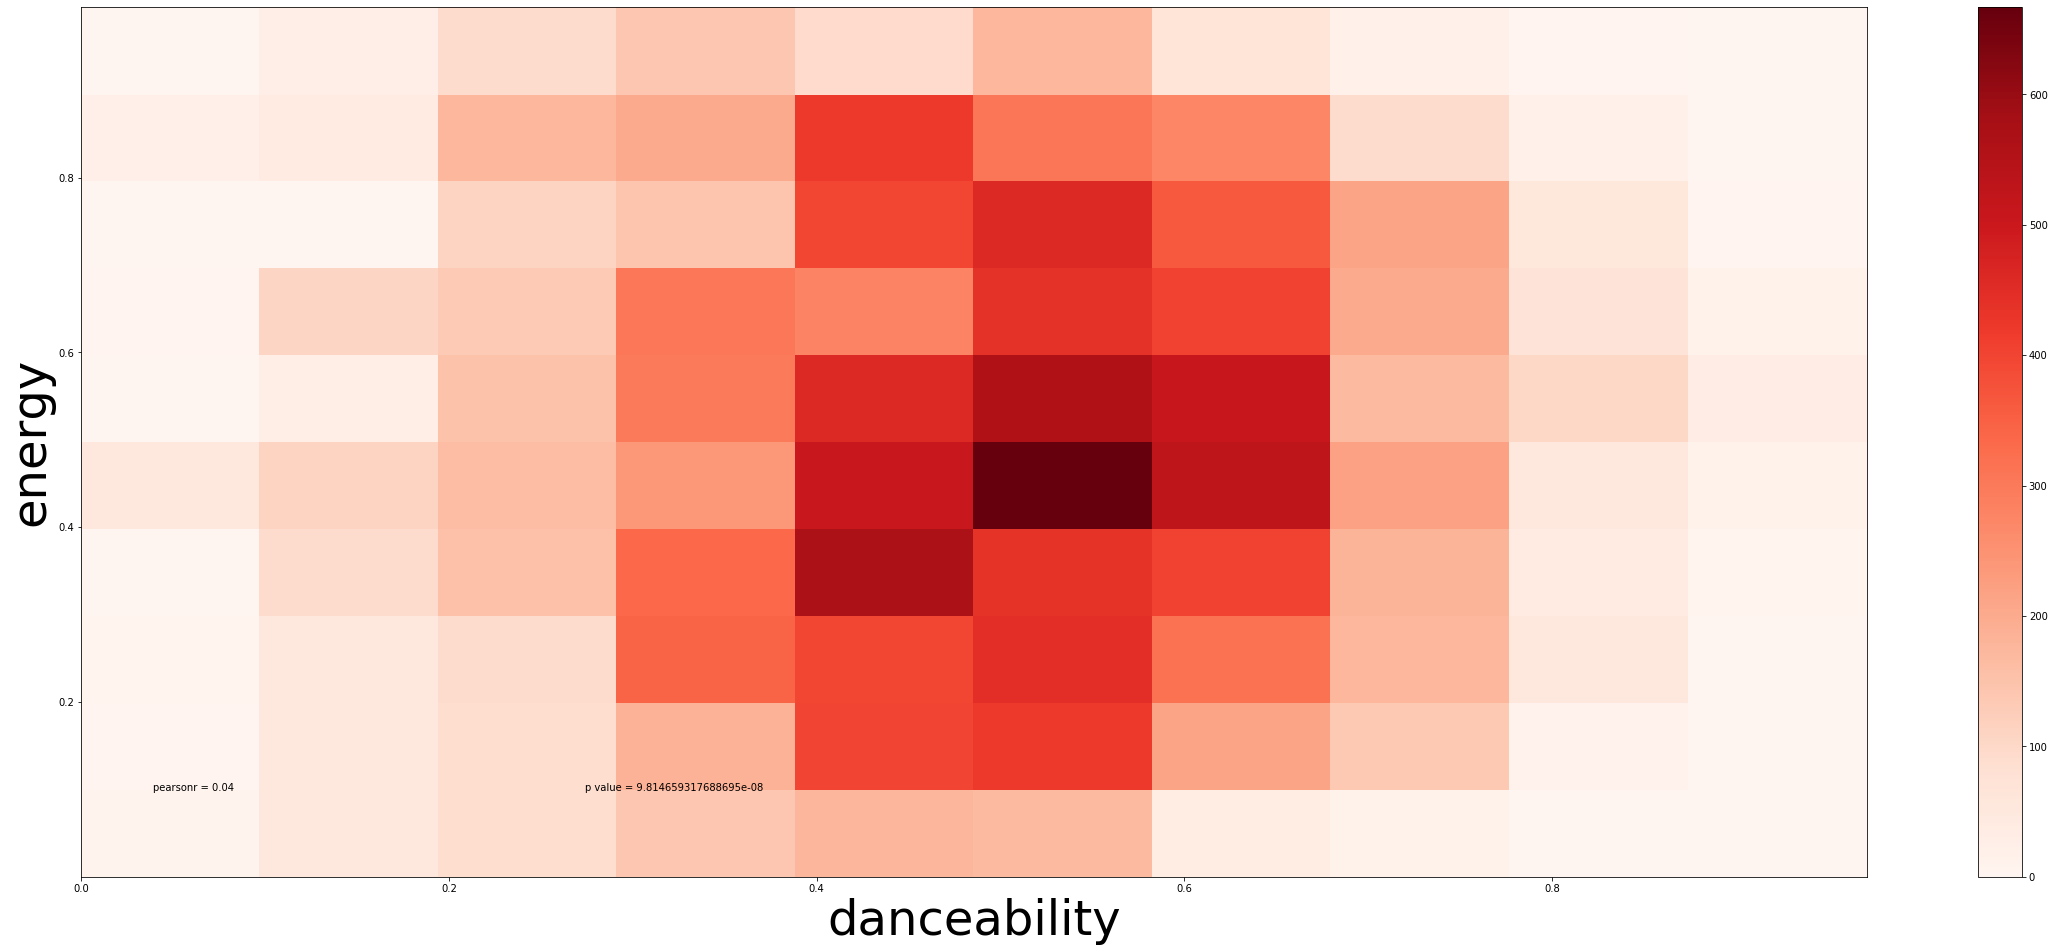

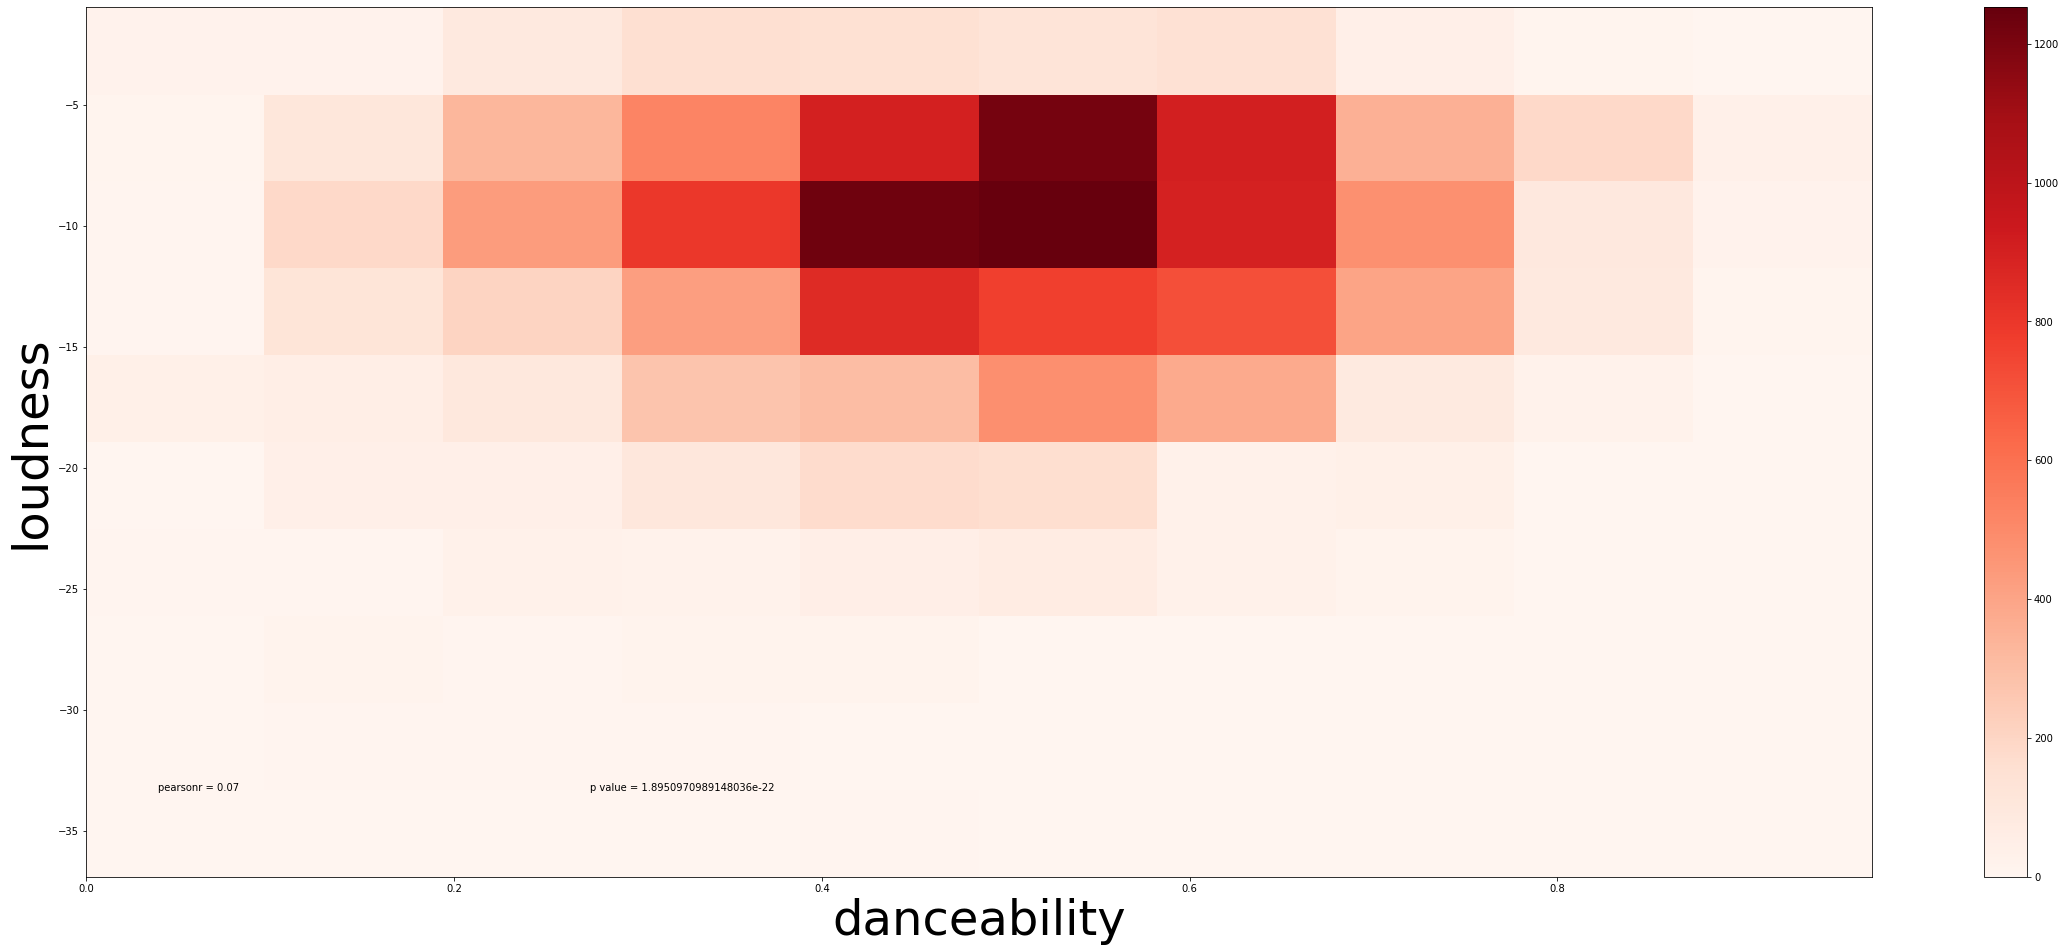

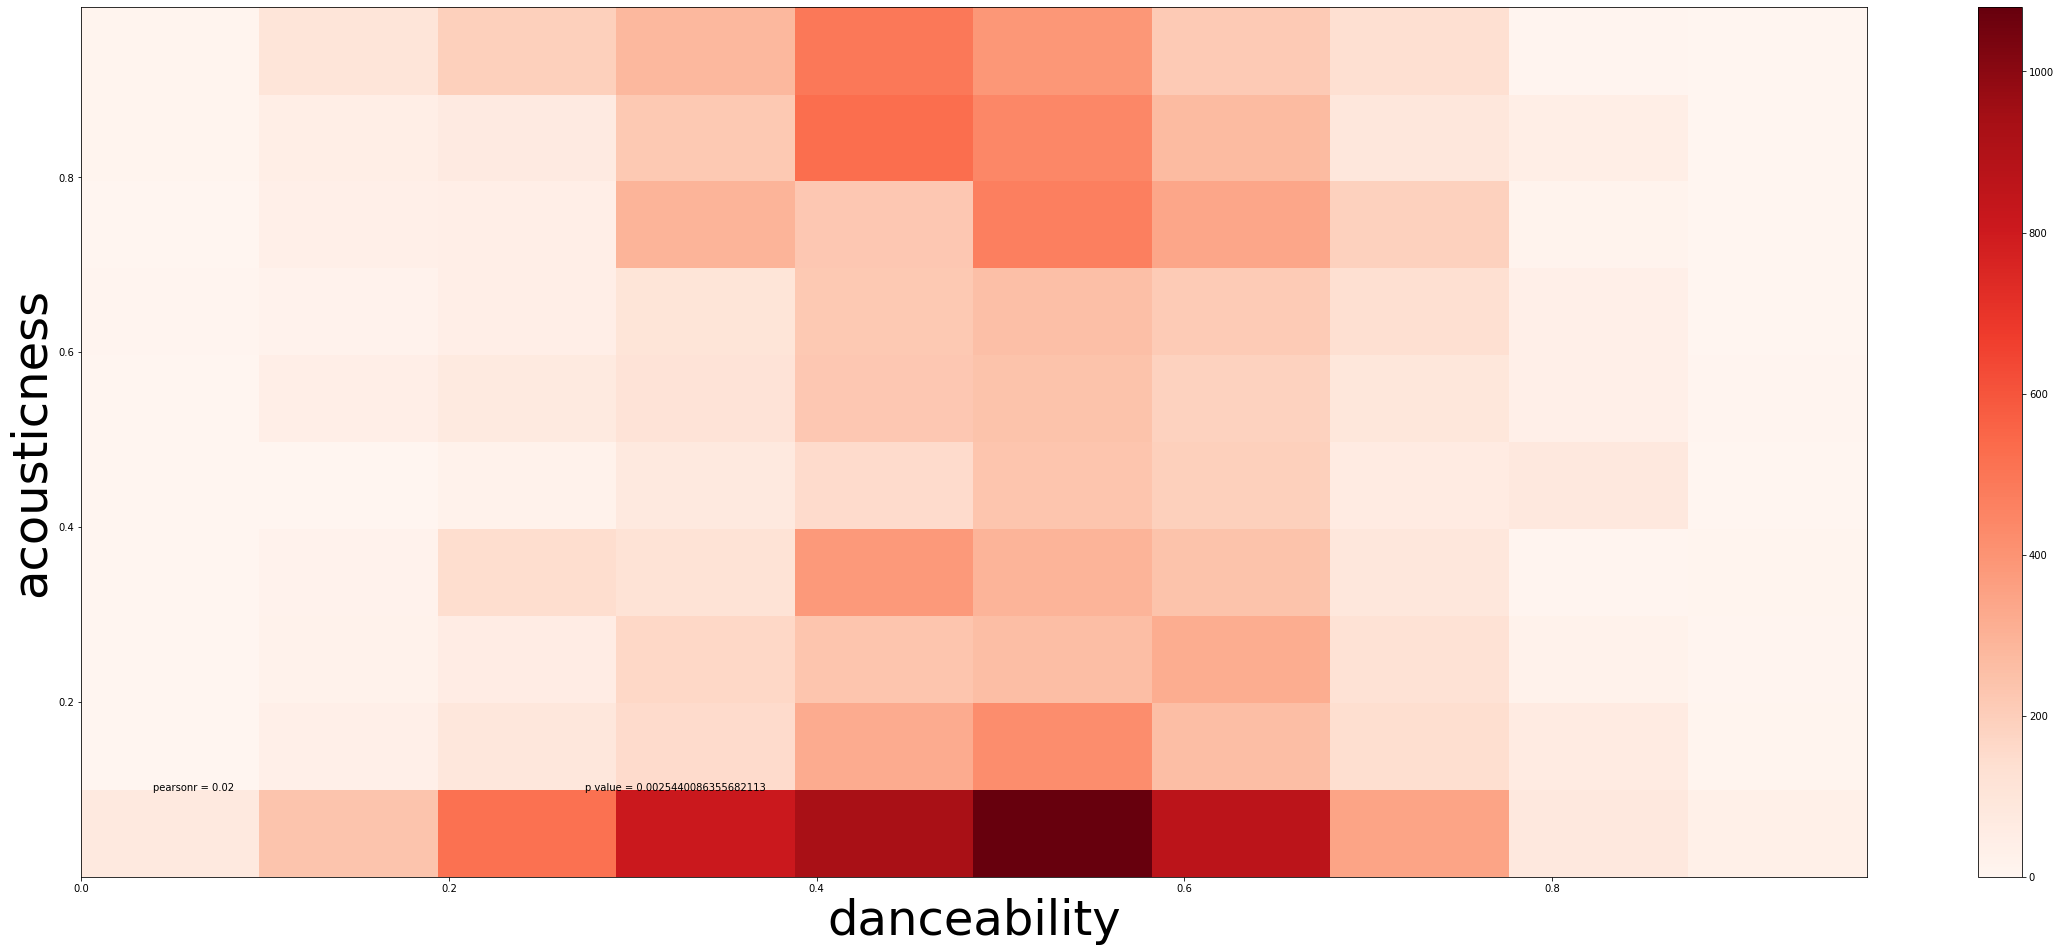

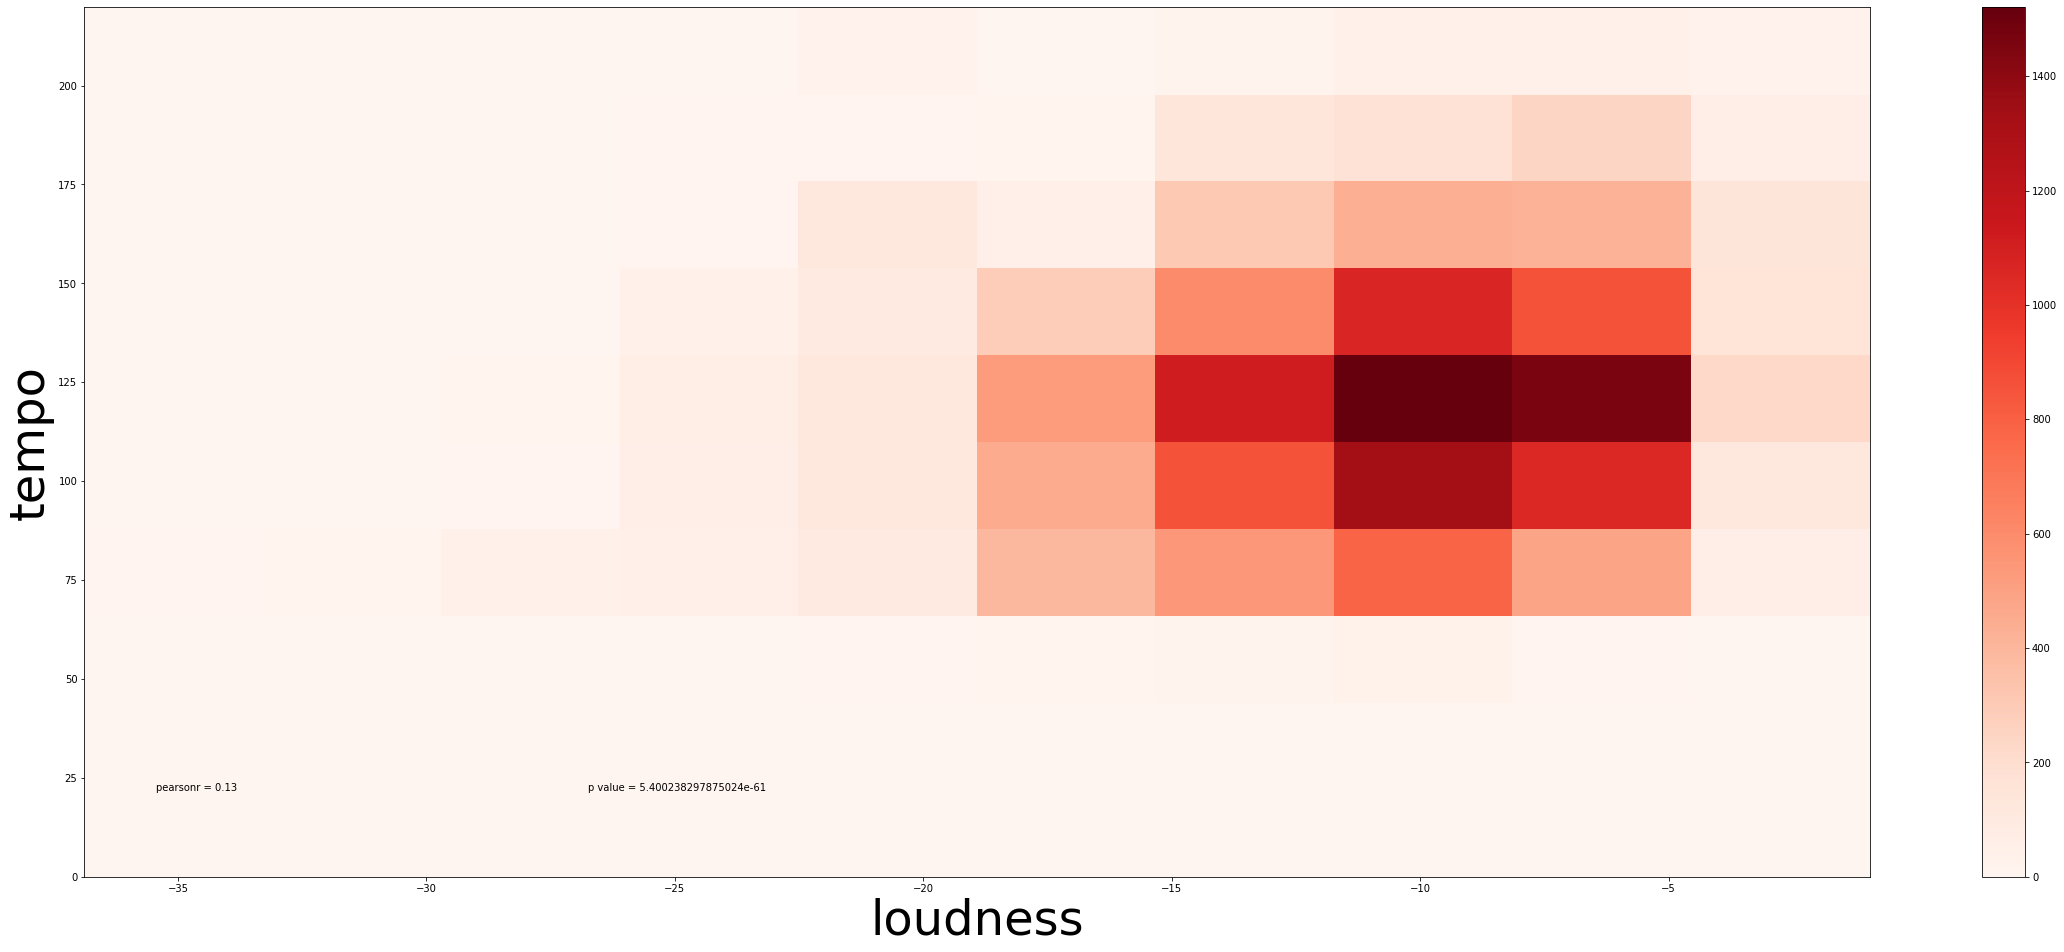

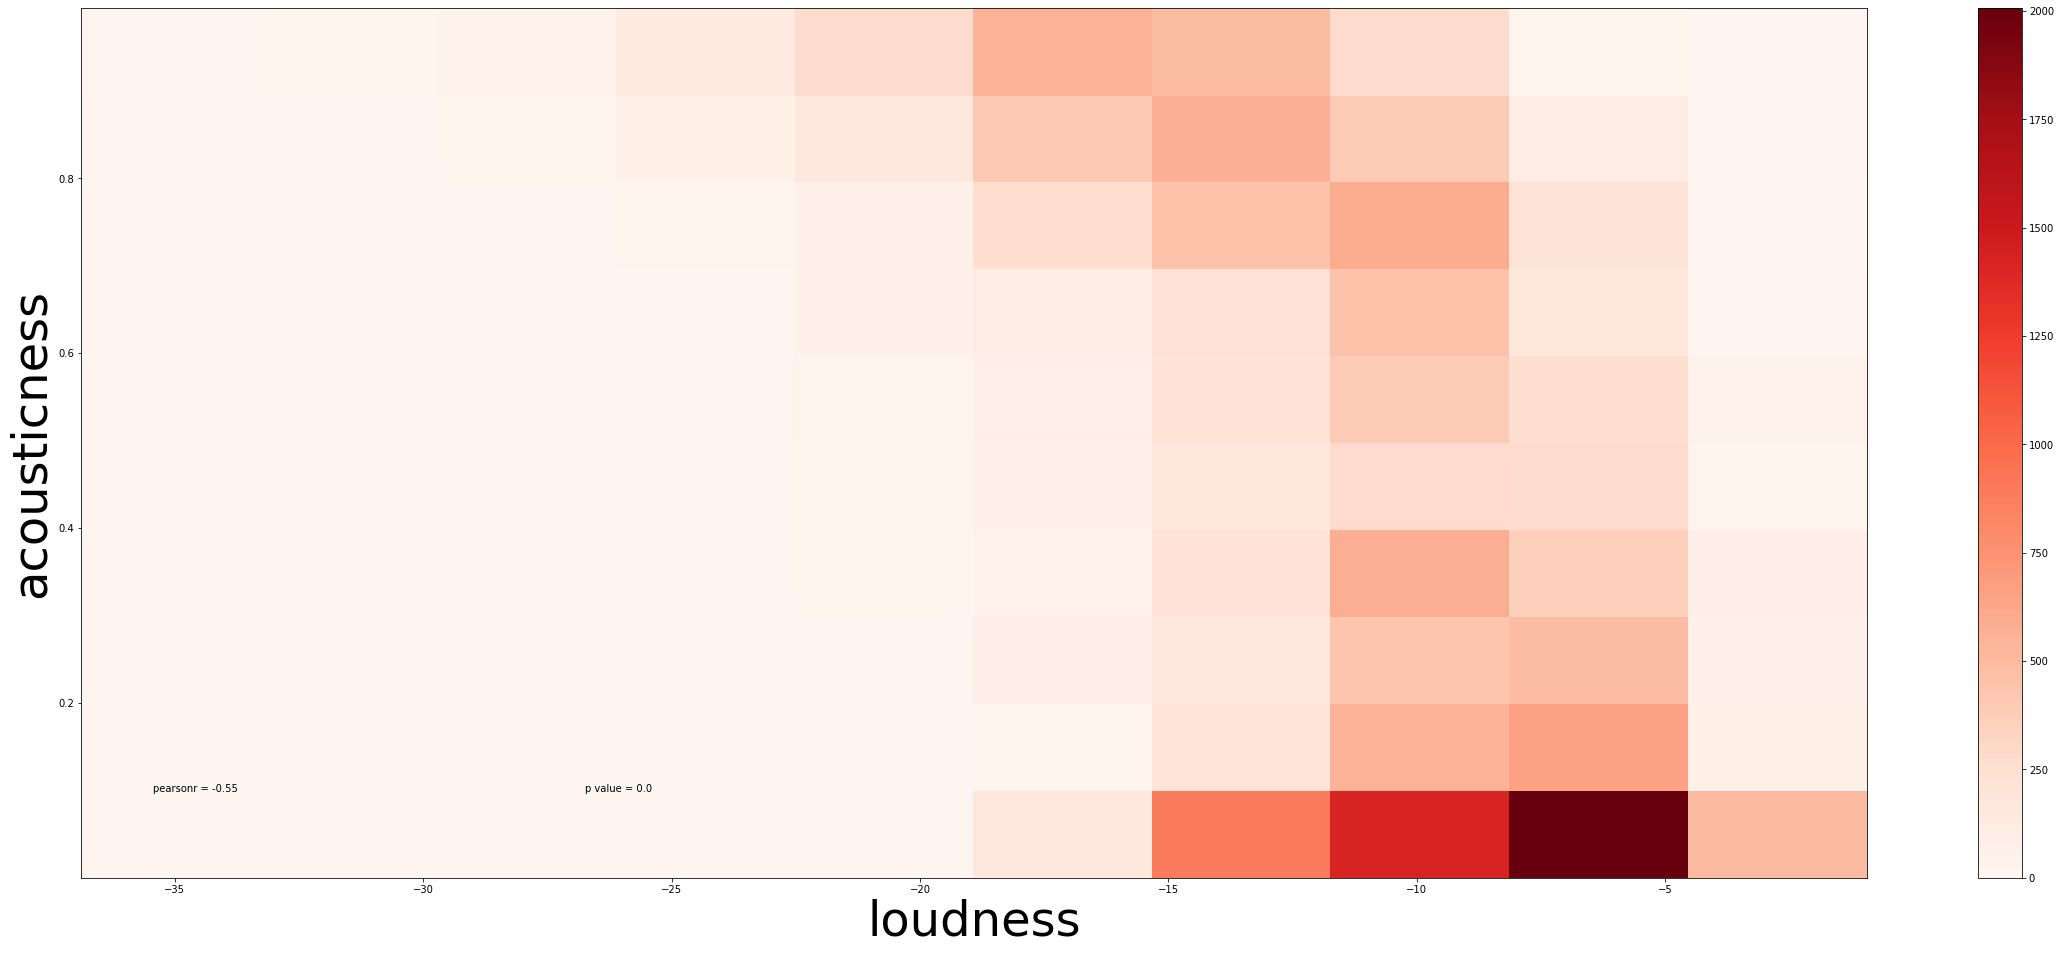

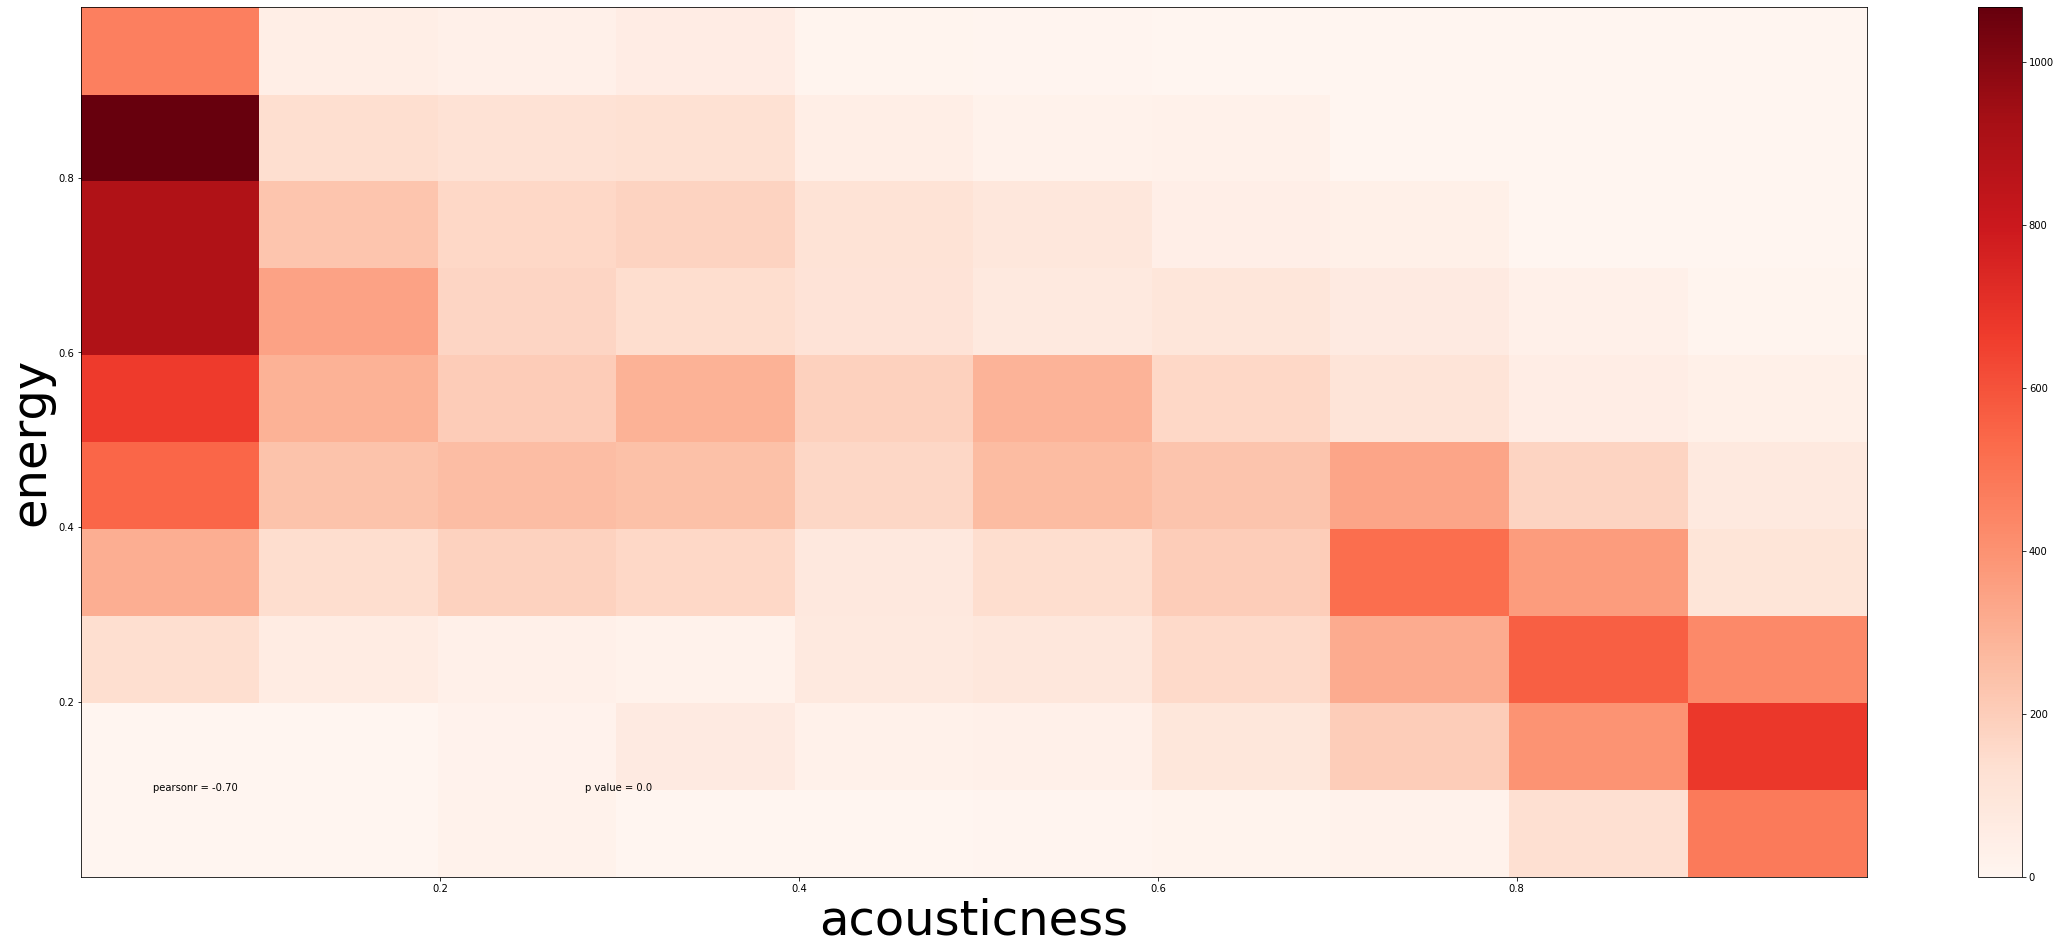

In [14]:
for pair in test_clusters:
    pear = scipy.stats.pearsonr(streamDF[pair[0]], streamDF[pair[1]])
    
    plt.figure(figsize=(40,16))
    plt.hist2d(streamDF[pair[0]], streamDF[pair[1]], (10, 10), cmap=plt.cm.Reds)

    plt.xlabel(pair[0], fontsize=48)
    plt.ylabel(pair[1], fontsize=48)
    
    plt.figtext(0.15, 0.2, 'pearsonr = ' + str('%.2f' % pear[0]), fontsize=10)
    plt.figtext(0.30, 0.2, 'p value = ' + str(pear[1]), fontsize=10)
    plt.colorbar()

##### As shown above in my scatterplots and heatmaps, I am starting to see correlations between the songs' attributes in my streaming history. As shown in these scatterplots, there is a positive correlation between the plots depicting “loudness and energy”, “tempo and energy”, and “loudness and danceability”, while there is a negative correlation between the plots depicting “acousticness and loudness” and “energy and acousticness”. With these correlations in mind, I am able to expect how the songs in my data are to be clustered together. 

In [ ]:
streamDF.info()

In [22]:
df = streamDF.iloc[:,6:16]
del df['danceability.1']
df.head()

,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo
0,71,0.290,0.000659,0.827,0.000003,0.301,-3.451,0.0362,167.086
1,66,0.489,0.877000,0.389,0.320000,0.105,-11.653,0.0284,131.366
2,69,0.549,0.583000,0.651,0.000000,0.121,-7.097,0.0323,122.818
3,56,0.622,0.650000,0.409,0.023000,0.142,-13.484,0.0362,86.173
4,58,0.609,0.086200,0.778,0.000012,0.278,-7.548,0.0485,122.614


In [29]:
#quantiles of data
df.describe()

,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo
count,17097.000000,17097.000000,17097.000000,17097.000000,17097.000000,17097.000000,17097.000000,17097.000000,17097.000000
mean,50.890273,0.490511,0.417079,0.491998,0.174457,0.178989,-10.843624,0.054349,120.013351
std,14.620516,0.157976,0.342623,0.235877,0.302702,0.153191,4.588170,0.061192,29.603236
min,0.000000,0.000000,0.000001,0.000070,0.000000,0.000000,-36.886000,0.000000,0.000000
25%,42.000000,0.388000,0.065200,0.307000,0.000009,0.097400,-13.479000,0.031500,97.005000
50%,51.000000,0.500000,0.365000,0.483000,0.001850,0.117000,-10.120000,0.037100,118.901000
75%,62.000000,0.603000,0.756000,0.678000,0.178000,0.192000,-7.476000,0.049900,137.755000
max,96.000000,0.971000,0.995000,0.995000,0.992000,0.981000,-0.946000,0.950000,219.840000


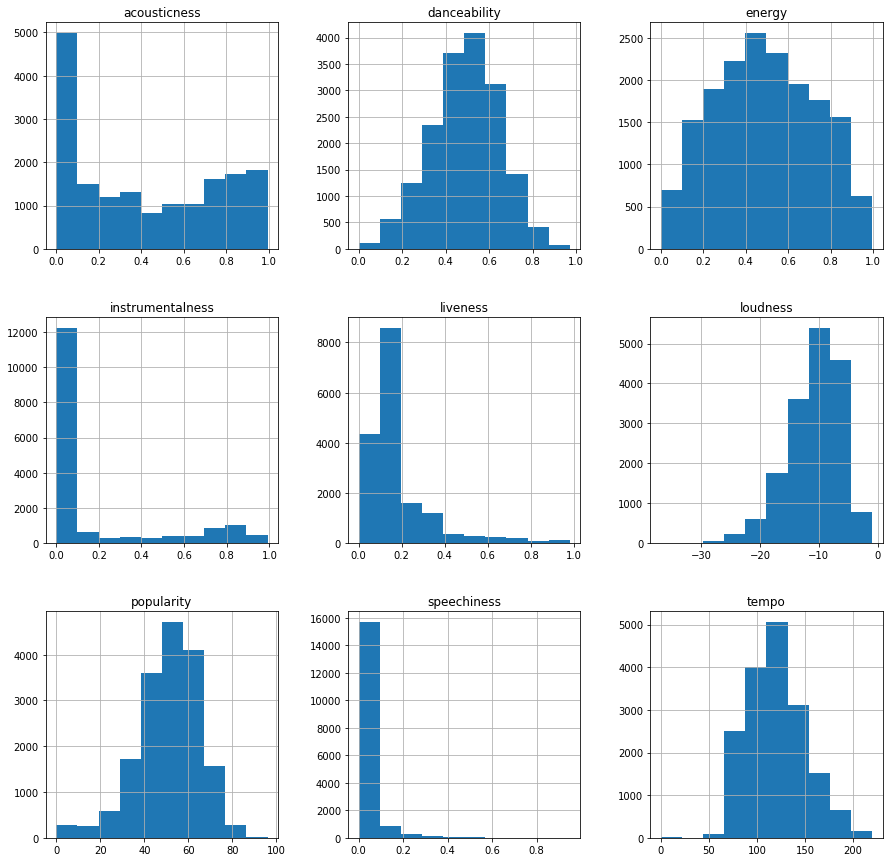

In [25]:
df.hist(figsize=(15,15));

##### In addition to visualizing the relationship between each attribute, I want to know how each attribute is distributed within the data. To visualize this distribution, I utilize the histogram function found in the Pandas library. This function allows me to plot out and visualize how frequently each attribute is distributed within each quantile, or equally sized subgroups, of the data.

##### It is evident from these histograms that, within my data, there are normal distributions for the attributes popularity, danceability, energy, and tempo, while there are non-normal distributions for the attributes acousticness, instrumentalness, liveness, loudness, and speechiness. Now that I understand how my data are both related and distributed, I can begin to cluster my data by their similarities.

In [26]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [28]:
# creating a copy of the dataset
df_cluster = streamDF.copy()
X = df.copy()

In [30]:
df_cluster.to_csv('df_spotify.csv', index=0)

In [31]:
X.columns

Index(['popularity', 'danceability', 'acousticness', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo'],
      dtype='object')

In [32]:
X.head()

,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo
0,71,0.290,0.000659,0.827,0.000003,0.301,-3.451,0.0362,167.086
1,66,0.489,0.877000,0.389,0.320000,0.105,-11.653,0.0284,131.366
2,69,0.549,0.583000,0.651,0.000000,0.121,-7.097,0.0323,122.818
3,56,0.622,0.650000,0.409,0.023000,0.142,-13.484,0.0362,86.173
4,58,0.609,0.086200,0.778,0.000012,0.278,-7.548,0.0485,122.614


In [33]:
print(X.shape)
df_cluster.head()

(17097, 9)


,Unnamed: 0,name,album,artist,release_date,length,popularity,danceability,acousticness,danceability.1,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,0,Holiday / Boulevard of Broken Dreams,American Idiot,Green Day,2004-09-21,493400,71,0.290,0.000659,0.290,0.827,0.000003,0.301,-3.451,0.0362,167.086,4
1,1,Jealous Guy - Remastered 2010,Imagine,John Lennon,1971-09-09,257786,66,0.489,0.877000,0.489,0.389,0.320000,0.105,-11.653,0.0284,131.366,4
2,2,Livin' Thing,A New World Record,Electric Light Orchestra,1976-09-01,212306,69,0.549,0.583000,0.549,0.651,0.000000,0.121,-7.097,0.0323,122.818,4
3,3,So Into You,A Rock And Roll Alternative,Atlanta Rhythm Section,1976-12,260866,56,0.622,0.650000,0.622,0.409,0.023000,0.142,-13.484,0.0362,86.173,4
4,4,Badlands,Darkness On the Edge of Town,Bruce Springsteen,1978-06-02,242453,58,0.609,0.086200,0.609,0.778,0.000012,0.278,-7.548,0.0485,122.614,4


##### To set all of my data at a scale from 0 to 1, I use the package MinMaxScalar included in the SKLearn Python library. Because clusters are determined by how far apart points are between each other when plotted, it helps to set the attributes on a common scale in order to create an evenly balanced clustering, where no attribute becomes more important than another. 

In [34]:
# data preprocessing
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [35]:
scaled = scaler.fit_transform(X)

##### Now that my data are scaled, I need to determine how many clusters would be optimal for my data. To achieve this, can utilize the “elbow method”, where If the line chart resembles an arm, then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point.

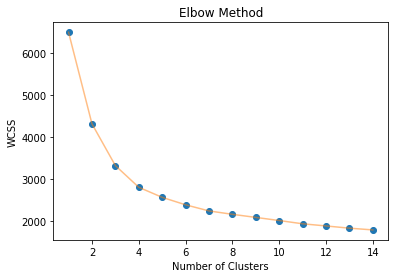

In [36]:
# finding out the proper number of clusters
wcss = []
for i in range(1,15):
  kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 17097, n_init = 10, random_state = 0)
  kmeans.fit(scaled)
  wcss.append(kmeans.inertia_)
plt.plot(range(1,15), wcss, 'o')
plt.plot(range(1 , 15) , wcss , '-' , alpha = 0.5)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.savefig('Elbow_Method.png')
plt.show()

In [38]:
wcss

[6505.390090098075,
 4320.34960477959,
 3323.896985177657,
 2805.992960219195,
 2566.0600999465364,
 2387.8945516346826,
 2242.1738772039876,
 2161.117956437519,
 2087.552659302632,
 2012.7957929253944,
 1934.94329535844,
 1883.7132394897476,
 1830.408705643106,
 1789.079979015411]

In [39]:
scaled = pd.DataFrame(scaler.fit_transform(X))
scaled.columns = cols

NameError: name 'cols' is not defined

In [42]:
scaled = scaler.fit_transform(X)

##### After creating a curve to determine the number of clusters I should divide my data into, shown in Figure 7, it is evident that, through the elbow method, I should create 4 clusters from my data. Using KMeans, a package also included within SKLearn, centroids, which are points assigned as the reference point each cluster based on the song attributes, can be created and plotted as a point in space. When the songs from my data are added to this space based on their attributes, they are assigned a cluster based on the highest proximity to 1 of 4 centroids. KMeans therefore allows every song in my dataframe to receive a specific cluster out of the 4.

In [85]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(scaled)

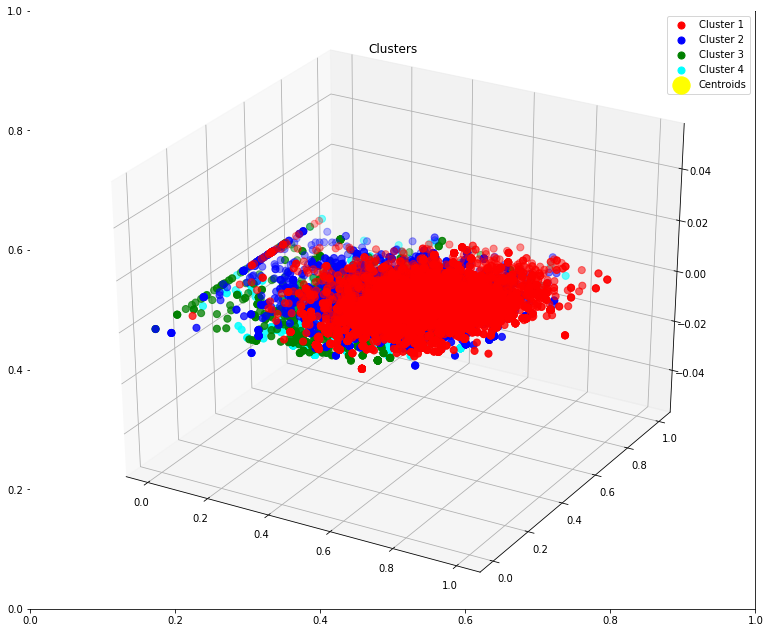

In [86]:
from mpl_toolkits.mplot3d import Axes3D
# visualizing clusters
fig, ax = plt.subplots(figsize=(13,11))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(scaled[y_kmeans == 0,0],scaled[y_kmeans == 0,1], s= 50, c= 'red',label= 'Cluster 1')
plt.scatter(scaled[y_kmeans == 1,0], scaled[y_kmeans == 1,1], s= 50, c= 'blue', label= 'Cluster 2')
plt.scatter(scaled[y_kmeans == 2,0], scaled[y_kmeans == 2,1], s= 50, c= 'green', label= 'Cluster 3')
plt.scatter(scaled[y_kmeans == 3,0], scaled[y_kmeans == 3,1], s= 50, c= 'cyan', label= 'Cluster 4')

# centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s= 300, c= 'yellow', label= 'Centroids')
plt.title('Clusters')
plt.legend()
plt.savefig('clusters.png')
plt.show()

In [87]:
# converting predictions into a df
kmeans = pd.DataFrame(data=y_kmeans, dtype=int)
kmeans.columns = ['k_cluster']

# predictions as a df
print(kmeans.shape)
kmeans.head()

(17097, 1)


,k_cluster
0,0
1,1
2,0
3,1
4,0


In [91]:
# concatenating the cluster column to the dataframe
del df_cluster['k_cluster']
df_cluster = pd.concat([df_cluster, kmeans], axis=1)

# checking the dataframe
print(df_cluster.shape)
df_cluster.head()

(17097, 18)


,Unnamed: 0,name,album,artist,release_date,length,popularity,danceability,acousticness,danceability.1,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,k_cluster
0,0,Holiday / Boulevard of Broken Dreams,American Idiot,Green Day,2004-09-21,493400,71,0.290,0.000659,0.290,0.827,0.000003,0.301,-3.451,0.0362,167.086,4,0
1,1,Jealous Guy - Remastered 2010,Imagine,John Lennon,1971-09-09,257786,66,0.489,0.877000,0.489,0.389,0.320000,0.105,-11.653,0.0284,131.366,4,1
2,2,Livin' Thing,A New World Record,Electric Light Orchestra,1976-09-01,212306,69,0.549,0.583000,0.549,0.651,0.000000,0.121,-7.097,0.0323,122.818,4,0
3,3,So Into You,A Rock And Roll Alternative,Atlanta Rhythm Section,1976-12,260866,56,0.622,0.650000,0.622,0.409,0.023000,0.142,-13.484,0.0362,86.173,4,1
4,4,Badlands,Darkness On the Edge of Town,Bruce Springsteen,1978-06-02,242453,58,0.609,0.086200,0.609,0.778,0.000012,0.278,-7.548,0.0485,122.614,4,0


In [92]:
# checking for null
(df_cluster.isnull().sum()/ df_cluster.shape[0]).sort_values(ascending=False)

k_cluster           0.0
time_signature      0.0
name                0.0
album               0.0
artist              0.0
release_date        0.0
length              0.0
popularity          0.0
danceability        0.0
acousticness        0.0
danceability.1      0.0
energy              0.0
instrumentalness    0.0
liveness            0.0
loudness            0.0
speechiness         0.0
tempo               0.0
Unnamed: 0          0.0
dtype: float64

##### By looking at the value counts for each cluster, I can see how different attributes are distributed within each cluster.

In [93]:
# energy mean by cluster
energyC = df_cluster.groupby(['k_cluster']).energy.mean().sort_values(ascending=False)
energyC

k_cluster
3    0.657408
0    0.626923
1    0.307953
2    0.287787
Name: energy, dtype: float64

In [94]:
# acousticness mean by cluster
acousticnessC = df_cluster.groupby(['k_cluster']).acousticness.mean().sort_values(ascending=False)
acousticnessC

k_cluster
2    0.800217
1    0.761470
0    0.162255
3    0.115211
Name: acousticness, dtype: float64

In [95]:
# tempo mean by cluster
tempoC = df_cluster.groupby(['k_cluster']).tempo.mean().sort_values(ascending=False)
tempoC

k_cluster
3    127.233616
0    123.103254
1    116.243973
2    108.308456
Name: tempo, dtype: float64

In [96]:
# danceability mean by cluster
danceabilityC = df_cluster.groupby(['k_cluster']).danceability.mean().sort_values(ascending=False)
danceabilityC

k_cluster
0    0.515200
1    0.508975
2    0.415830
3    0.401377
Name: danceability, dtype: float64

In [97]:
# instrumentalness mean by cluster
instrumentalnessC = df_cluster.groupby(['k_cluster']).instrumentalness.mean().sort_values(ascending=False)
instrumentalnessC

k_cluster
2    0.771842
3    0.709045
0    0.028522
1    0.025093
Name: instrumentalness, dtype: float64

In [98]:
# checking number of songs in each cluster
df_cluster['k_cluster'].value_counts()

0    7607
1    5925
3    2143
2    1422
Name: k_cluster, dtype: int64

In [99]:
df_cluster.to_csv('df_cluster.csv', index=0)

##### With every song in my dataframe having received a cluster, I am now ready to transfer these songs to playlists on Spotify that correspond to each cluster. Using SpotiPy to access the Spotify Web API, I am able to create playlists directly onto my personal Spotify account as well as add songs to them while only using Python. Grouping by each cluster, I can successfully transfer each cluster of songs to newly created playlists on Spotify

In [100]:
def GetTrackIDs(sample_data, titles):
    #Get Spotify track ids for samples
    track_ids = []
    #Track Info Box Flow
    for i in range(len(sample_data)):
        results = sp.search(q=f"{sample_data['name'][i]} {sample_data['artist'][i]} ", limit=5, type='track') #get 5 responses since first isn't always accurate
        if results['tracks']['total'] == 0: #if track isn't on spotify as queried, go to next track
            continue
        else:
            for j in range(len(results['tracks']['items'])):
                if fuzz.partial_ratio(results['tracks']['items'][j]['artists'][0]['name'], sample_data['artist'][i]) > 90 and fuzz.partial_ratio(results['tracks']['items'][j]['name'], sample_data['name'][i]) > 90 : #get right response by matching on artist and title
                    track_ids.append(results['tracks']['items'][j]['id']) #append track id
                    streamDF['id'][i] = results['tracks']['items'][j]['id']
                    break #don't want repeats of a sample ex: different versions
                else:
                    continue
    print("Got TrackIDs")
    return track_ids

In [101]:
j = pd.read_csv("MySongs.csv")
j['cluster'] = df_cluster['k_cluster']
del j['Unnamed: 0']
del j['Unnamed: 0.1']
j

,name,album,artist,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,cluster,id
0,Holiday / Boulevard of Broken Dreams,American Idiot,Green Day,2004-09-21,493400,71,0.290,0.000659,0.8270,0.000003,0.3010,-3.451,0.0362,167.086,4,0,0MsrWnxQZxPAcov7c74sSo
1,Jealous Guy - Remastered 2010,Imagine,John Lennon,1971-09-09,257786,66,0.489,0.877000,0.3890,0.320000,0.1050,-11.653,0.0284,131.366,4,1,3D9iV6cYkYJRAPFO6DRKIE
2,Livin' Thing,A New World Record,Electric Light Orchestra,1976-09-01,212306,69,0.549,0.583000,0.6510,0.000000,0.1210,-7.097,0.0323,122.818,4,0,2hdNya0b6Cc2YJ8IyaQIWp
3,So Into You,A Rock And Roll Alternative,Atlanta Rhythm Section,1976-12,260866,56,0.622,0.650000,0.4090,0.023000,0.1420,-13.484,0.0362,86.173,4,1,3Sm5TYFgMXyXwgAcY2xweX
4,Badlands,Darkness On the Edge of Town,Bruce Springsteen,1978-06-02,242453,58,0.609,0.086200,0.7780,0.000012,0.2780,-7.548,0.0485,122.614,4,0,0M1YQiRGel1tTMjA3orfRd
5,Walk On the Wild Side,Transformer,Lou Reed,1972-12-01,254173,75,0.575,0.683000,0.3180,0.000202,0.0934,-16.729,0.1090,104.522,4,1,5p3JunprHCxClJjOmcLV8G
6,Lovely Day,Menagerie,Bill Withers,1977-10-29,254560,75,0.690,0.292000,0.6510,0.002410,0.1050,-8.267,0.0324,97.918,4,0,0bRXwKfigvpKZUurwqAlEh
7,Mr. Blue Sky,Out of the Blue,Electric Light Orchestra,1977,303373,80,0.388,0.652000,0.3380,0.000004,0.2480,-10.054,0.0328,177.784,4,1,2RlgNHKcydI9sayD2Df2xp
8,Maggie May,Every Picture Tells A Story,Rod Stewart,1971-05-18,350266,72,0.605,0.559000,0.5740,0.113000,0.0684,-10.536,0.0377,129.449,4,1,6rovOdp3HgK1DeAMYDzoA7
9,Fire and Rain - 2019 Remaster,Sweet Baby James (2019 Remaster),James Taylor,1970-02-01,203613,73,0.597,0.766000,0.2710,0.011900,0.0933,-17.293,0.0394,76.271,4,1,1oht5GevPN9t1T3kG1m1GO


In [102]:
badID = j[j['id'].str.contains(" ")]
#badID
j = pd.concat([j, badID, badID]).drop_duplicates(keep=False)

In [103]:
import spotipy.util as util

In [104]:
client_id = 'a3d6d87d03994a91883e343e37baff9d'
client_secret = '6182efe43d384dd9b431151ea75d6901'

username = 'jdarby00'
redirect_uri = 'http://localhost:9999/callback/'

In [105]:
scope1 = 'playlist-modify-private'
scope2 = 'playlist-modify-public'

In [106]:
token = util.prompt_for_user_token(username, scope1, client_id, client_secret, redirect_uri)
sp = spotipy.Spotify(auth=token)
token = util.prompt_for_user_token(username, scope2, client_id, client_secret, redirect_uri)
sp = spotipy.Spotify(auth=token)

In [107]:
def addTracks(username, trackIDs, playlistID):
    extra = int(len(trackIDs) % 100)
    whole = int(len(trackIDs) - extra)
    num = int(whole / 100)
    try:
        for i in range(0, num):
            ids = trackIDs[((i*100)+1):((i*100)+100)]
            sp.user_playlist_add_tracks(username, playlistID, ids)
    except:
        print('error')
    try:
        ids = trackIDs[(whole+1):(whole+extra)]
        sp.user_playlist_add_tracks(username, playlistID, ids)
    except:
        print('error2')

In [108]:
def makePlaylists(df):
    for i in range(len(df['cluster'].unique())):
        songs = df.loc[df['cluster'] == i]
        ids = 'spotify:track:' + songs['id']
        ids = ids.drop_duplicates()
        playlist_name = 'cluster ' + str(i)
        PL = sp.user_playlist_create(username, name=playlist_name)
        PLID = PL['id']
        addTracks(username, ids, PLID)

In [110]:
#Create playlists on Spotify

#makePlaylists(j)

##### The playlists are now on Spotify and ready to enjoy! :-)